In [1]:
#!pip install --upgrade pip
!pip install kaggle
#!kaggle datasets create -p /kaggle/working/processed -u alimehrabi -t "Processed CHB-MIT 19ch fixedlen"
!pip install --quiet torch torchvision snntorch mne 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.5 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 965.0 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependen

In [2]:
# ============================================================
# Core Libraries
# ============================================================
import os
import time
import math
import gc
import re
import warnings
from contextlib import nullcontext
from typing import Tuple, Optional, Callable, Dict, List
from collections import Counter, deque, defaultdict

# ============================================================
# Numerical & Scientific Libraries
# ============================================================
import numpy as np
import pandas as pd
from scipy.signal import lfilter
import h5py

# ============================================================
# EEG & Signal Processing
# ============================================================
import mne

# ============================================================
# Plotting
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# Machine Learning & Metrics
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

# ============================================================
# PyTorch / SNN Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import snntorch as snn
from snntorch import surrogate

# ============================================================
# CHB-MIT Patient Metadata
# ============================================================
patient = {
    "patient21": {
        "edf": ["chb21_19.edf", "chb21_20.edf", "chb21_21.edf", "chb21_22.edf"],
        "seizures": [[1288, 1344], [2627, 2677], [2003, 2074], [2553, 2565]],
    },
    "patient24": {
        "edf": [
            "chb24_01.edf", "chb24_03.edf", "chb24_04.edf", "chb24_09.edf",
            "chb24_11.edf", "chb24_13.edf", "chb24_14.edf", "chb24_15.edf",
            "chb24_17.edf", "chb24_21.edf",
        ],
        "seizures": [
            [480,505,2451,2476], [231,260,2883,2908],
            [1088,1120,1411,1438,1745,1764], [1745,1764], [3527,3597],
            [3288,3304], [1939,1966], [3552,3569], [3515,3581], [2804,2872],
        ],
    },
    "patient03": {
        "edf": ["chb03_01.edf", "chb03_02.edf", "chb03_03.edf", "chb03_04.edf"],
        "seizures": [[362, 414], [731, 769], [432, 501], [2162, 2214]],
    },
    "patient01": {
        "edf": ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf"],
        "seizures": [[2996, 3036], [1467, 1494], [1732, 1772], [1015, 1066]],
    },
    "patient17": {
        "edf": ["chb17a_03.edf", "chb17a_04.edf", "chb17b_63.edf"],
        "seizures": [[2282, 2372], [3025, 3140], [3136, 3224]],
    },
    "patient14": {
        "edf": [
            "chb14_03.edf", "chb14_04.edf", "chb14_06.edf",
            "chb14_11.edf", "chb14_17.edf", "chb14_18.edf", "chb14_27.edf",
        ],
        "seizures": [
            [1986,2000], [1372,1392,2817,2839], [1911,1925],
            [1838,1879], [3239,3259], [1039,1061], [2833,2849],
        ],
    },
}


# Patient Dictionary with Seizure Annotations

We first define the patient dictionary containing the EEG .edf files for six patients and their seizure intervals (in seconds). Each patient entry includes a list of .edf filenames and a parallel list of seizure interval lists for those files (empty list if no seizure in that file). We focus on files that contain seizures for brevity (files without seizures are omitted here, but would be labeled entirely as non-seizure). The six patients chosen are cases 18 through 23 from the CHB-MIT database, each having annotated seizures:

In [ ]:
#Parameters

# --- Config ---
DATA_PATH =  "/kaggle/input/eeg-chb-mit/"
OUT_PATH = "./preprocessed_npz"
WINDOW_SIZE = 128
OVERLAP = 64
THRESHOLD = 0.5
EXPECTED_CHANNELS = 19
SAMPLE_RATIO = 0.25
BATCH_SIZE = 64
n_inputs = 23           # 23 EEG channels
n_hidden = 69           # 2x input neurons
n_outputs = 2           # Seizure / Non-seizure
EPOCHS = 100
DELTAX = 0.2

## Preprocessing, Window Labelling, and Sigma–Delta Spike Encoding

This section prepares the EEG data stored in `.npz` files for Spiking Neural Network (SNN) training. It implements seizure-interval normalisation, sigma–delta spike encoding, window-level labelling, and construction of the spike-encoded dataset.

---

### 1. Output Directory Setup
```python
os.makedirs(OUT_PATH, exist_ok=True)
Ensures that the output directory exists before saving processed files.
```
### 2. Normalising Seizure Annotations
```python
def normalize_seizure_intervals(sz_list):
    ...
```
Seizure annotations in CHB-MIT appear in two formats:

Flat lists:
[1088,1120,1411,1438,...]

Nested lists:
[[1088,1120], [1411,1438], ...]

This function standardises both formats into (start, end) tuples and:

Splits flat lists into sequential pairs

Corrects reversed intervals (when end < start)

Ignores malformed entries

A unified format is required for consistent seizure labelling.

### 3. Sigma–Delta Spike Encoding
python
Copy code
def sigma_delta_encode(signal):
    ...
Implements first-order sigma–delta modulation, a neuromorphic spike-encoding method:

Emit a spike (1) when the signal rises above the internal state

Update the internal state using a leak term (DELTAX)

Output a binary spike train capturing rapid EEG dynamics

This encoding is computationally efficient and well-suited for SNNs.

### 4. Window-Level Seizure Labelling
```python
def label_window(start, seizure_intervals, sfreq, win_size, threshold):
   ...
```
Each window is labelled as seizure if the proportion of its duration overlapping with any seizure interval exceeds threshold.

Procedure:

Convert window start/end from samples to seconds

Compute overlap with each seizure interval

Accumulate total overlap

Label as seizure (1) if:

overlap
window length
≥
threshold
window length
overlap
​
 ≥threshold
This approach handles partial overlaps and gives smooth temporal labels.

### 5. Building the Spike-Encoded Dataset
``` python
def build_dataset_from_npz(npz_dir, window_size=32, overlap=0, threshold=0.2):
    ...
```
This function converts all .npz EEG recordings into a spike-encoded dataset using sigma–delta encoding.

For each recording:

Load normalised EEG (data) and seizure intervals (seizures)

Slide a window across time with size window_size and given overlap

For each window:

Extract continuous EEG segment (C, window_size)

Encode each channel → sigma–delta spikes (C, window_size)

Label using label_window()

Append spike windows and labels to the dataset

Outputs:

X_all: spike trains (N, C, window_size)

y_all: binary seizure labels (N,)

Printed summary with seizure percentage

In [ ]:

os.makedirs(OUT_PATH, exist_ok=True)

def normalize_seizure_intervals(sz_list):
    """
    Normalize seizure annotations to a list of (start, end) tuples.
    Handles both:
      - flat lists like [1088,1120,1411,1438,1745,1764]
      - nested lists like [[1088,1120], [1411,1438]]
    Automatically fixes reversed (end < start) pairs.
    """
    normalized = []

    # Case 1: flat list of numbers
    if all(isinstance(x, (int, float)) for x in sz_list):
        for i in range(0, len(sz_list), 2):
            if i + 1 >= len(sz_list):
                break
            s, e = sz_list[i], sz_list[i + 1]
            if e < s:
                s, e = e, s  # swap if reversed
            normalized.append((float(s), float(e)))

    # Case 2: list of lists or tuples
    elif all(isinstance(x, (list, tuple)) for x in sz_list):
        for pair in sz_list:
            if len(pair) < 2:
                continue
            s, e = pair[0], pair[1]
            if e < s:
                s, e = e, s
            normalized.append((float(s), float(e)))


           
# --- Sigma-delta encoding ---
def sigma_delta_encode(signal):
    spike_train = []
    prev_spike = 0
    for val in signal:
        spike = 1.0 if val > prev_spike else 0.0
        prev_spike += spike - DELTAX
        spike_train.append(spike)
    return np.array(spike_train, dtype=np.float32)



def label_window(start, seizure_intervals, sfreq, win_size, threshold):
    """
    seizure_intervals: list of (start, end) tuples in seconds
    """
    win_start_sec = start / sfreq
    win_end_sec = (start + win_size) / sfreq
    seizure_overlap = 0.0

    for (sz_start, sz_end) in seizure_intervals:
        overlap = max(0, min(win_end_sec, sz_end) - max(win_start_sec, sz_start))
        seizure_overlap += overlap

    return int((seizure_overlap / (win_size / sfreq)) >= threshold)



# --- Convert windows to spike dataset ---
def build_dataset_from_npz(npz_dir, window_size=32, overlap=0, threshold=0.2):
    all_X, all_y = [], []
    step = window_size - overlap

    for fname in os.listdir(npz_dir):
        if not fname.endswith(".npz"):
            continue
        npz_path = os.path.join(npz_dir, fname)
        data_obj = np.load(npz_path, allow_pickle=True)
        data = data_obj["data"]
        sfreq = int(data_obj["sfreq"])
        sz_times = data_obj["seizures"]

        for start in range(0, data.shape[1] - window_size + 1, step):
            win = data[:, start:start+window_size]
            spikes = np.array([sigma_delta_encode(ch) for ch in win])  # (C, L)
            label = label_window(start, sz_times, sfreq, window_size, threshold)
            all_X.append(spikes)
            all_y.append(label)

    X_all = np.stack(all_X)
    y_all = np.array(all_y)
    print(f"Dataset built: X={X_all.shape}, y={y_all.shape}, Seizure % = {100*np.mean(y_all):.2f}%")
    return X_all, y_all


In [22]:

def plot_spike_raster_with_label(spikes, label, window_index=None):
    assert spikes.ndim == 2, "Expected shape (channels, time)"
    C, T = spikes.shape

    fig, ax = plt.subplots(figsize=(10, 5))

    # Build spike coordinates
    for ch in range(C):
        times = np.where(spikes[ch] > 0)[0]
        ax.vlines(times, ch - 0.4, ch + 0.4, color='black')

    ax.set_ylim(-1, C)
    ax.set_xlim(0, T)
    ax.set_yticks(range(C))
    ax.set_yticklabels([f"Ch{c+1}" for c in range(C)])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Channel")
    
    title = f"Spike Raster - {'SEIZURE' if label == 1 else 'Non-Seizure'}"
    if window_index is not None:
        title += f" (Window {window_index})"
    ax.set_title(title, color='red' if label == 1 else 'black')

    # Optional: background color to indicate seizure
    if label == 1:
        ax.axvspan(0, T, color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()


def plot_spike_raster(ax, spikes, label, title):
    """
    Plot a spike raster on the given axes.
    """
    C, L = spikes.shape
    for ch in range(C):
        spike_times = np.where(spikes[ch] > 0)[0]
        ax.vlines(spike_times, ch + 0.5, ch + 1.5, color='black', linewidth=0.4)

    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Time")
    ax.set_ylabel("Channel")
    ax.set_ylim(0.5, C + 0.5)
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.3)

def plot_multiple_spike_rasters(X, y, num_samples=3, figsize=(12, 6)):
    """
    Plot multiple spike rasters for seizure (y=1) and non-seizure (y=0) samples.
    """
    seizure_idxs = [i for i, lbl in enumerate(y) if lbl == 1][:num_samples]
    nonseizure_idxs = [i for i, lbl in enumerate(y) if lbl == 0][:num_samples]

    total = 2 * num_samples
    fig, axes = plt.subplots(2, num_samples, figsize=figsize, sharey=True)

    for i, idx in enumerate(nonseizure_idxs):
        plot_spike_raster(axes[0, i], X[idx], 0, f"Non-Seizure #{i+1}")
    for i, idx in enumerate(seizure_idxs):
        plot_spike_raster(axes[1, i], X[idx], 1, f"Seizure #{i+1}")

    axes[0, 0].set_ylabel("Channels\nNon-Seizure")
    axes[1, 0].set_ylabel("Channels\nSeizure")
    plt.suptitle(f"Spike Rasters for {num_samples} Seizure and Non-Seizure Samples", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



### End-to-End EEG Preprocessing, Channel Selection, Balancing, Dual Spike Encoding, and Visualisation

This section implements the full preprocessing pipeline that takes raw CHB-MIT EDF files, cleans and standardises channels, discovers a common channel set across patients, exports normalised NPZ files, builds and rebalances windowed datasets, converts them into dual spike encodings (Sigma–Delta + Poisson rate), and finally provides tools for visualising spike rasters and exporting them to PDF.

---

## 1. Channel Cleaning and Canonicalisation

**Configuration constants:**
- `EXCLUDE_KEYWORDS` — labels used to discard non-EEG signals (e.g. `"ECG"`, `"EMG"`, `"PHOT"`, `"A1"`, `"A2"`).  
- `ZERO_TOL` — absolute magnitude below which a sample is treated as zero.  
- `VAR_TOL` — variance threshold below which a channel is considered flat/empty.

**Functions:**

- `canonicalize_name(ch)`  
  - Normalises a channel name by:
    - Stripping whitespace  
    - Converting to uppercase  
    - Removing deduplication suffixes like `"_7"`  
  - Used to match channels consistently across EDFs and patients.

- `is_nonempty_channel(x, zero_tol, var_tol)`  
  - Decides whether a channel contains meaningful data:  
    - Handles NaNs by focusing on finite values only.  
    - Rejects channels that are all (near-)zero.  
    - Rejects channels with extremely low variance (flat or dead channels).

- `drop_non_eeg_channels(raw)`  
  - Removes obvious junk labels (e.g. `"-"`, `"--0"` …) and any channel whose name contains an exclusion keyword such as `"ECG"` or `"EMG"`.  
  - Ensures only EEG-relevant channels remain.

- `rename_duplicates(raw)`  
  - EDF files can contain duplicate channel labels, which can break indexing.  
  - This function:
    - Detects duplicates within an EDF.  
    - Renames them to unique variants (`F7`, `F7_0`, `F7_1`, …).  
    - Preserves a canonical view via `canonicalize_name` (which strips the suffix).  

Together, these functions clean the channel namespace and ensure stable, unique channel names.

---

## 2. Seizure Annotation Normalisation

- `normalize_seizure_intervals(sz_list)`  
  - Converts seizure metadata into a unified list of `(start, end)` tuples (in seconds or samples, depending on usage).  
  - Supports:
    - Flat lists: `[start1, end1, start2, end2, ...]`  
    - List of pairs: `[[start1, end1], [start2, end2], ...]`  
  - Automatically swaps reversed intervals (`end < start`) and ignores malformed entries.  
  - Prints a warning if the format is unexpected.

This unified representation is reused for window-level labelling.

---

## 3. Discovering Common Non-Empty Channels and Saving NPZ Files

- `discover_common_nonempty_channels(patient_dict, data_path)`  
  - For each patient:
    - Loads all EDFs listed in `patient_dict`.  
    - Applies `drop_non_eeg_channels` and `rename_duplicates`.  
    - Builds a mapping from canonical channel names → EDF indices.  
    - Uses `is_nonempty_channel` to determine which canonical channels carry valid data in each EDF.  
    - Intersects these sets across all EDFs for that patient.  
  - Then intersects per-patient sets across all patients to obtain a global `COMMON_CHANNELS` list.  
  - Prints diagnostics about how many channels are retained per patient and globally.

- `preprocess_and_save(patient_dict, data_path, out_path, common_channels)`  
  - For each EDF file:
    - Loads the signal with MNE and re-applies channel cleaning and deduplication.  
    - Builds a canonical name → indices map.  
    - Verifies each `common_channels` entry exists and is non-empty; skips files where required channels are missing.  
    - Extracts only the `COMMON_CHANNELS` in a fixed order.  
    - Performs per-channel z-score normalisation.  
    - Normalises seizure annotations using `normalize_seizure_intervals`.  
    - Saves each recording as a compressed `.npz` with:
      - `data` (C×T array),  
      - `sfreq` (sampling frequency),  
      - `seizures` (intervals),  
      - `channel_names` (global channel list).  

This yields a set of consistent, normalised NPZ files across all patients.

---

## 4. Windowing, Labelling, and Class Balancing

- `label_window(start_sample, seizure_intervals, sfreq, win_size, threshold)`  
  - Computes a binary seizure label for a window beginning at `start_sample`:
    - Converts start/end of window into seconds.  
    - Ensures seizure intervals are a list of `(start, end)` pairs (flat-format compatible).  
    - Computes total time overlap between the window and all seizure intervals.  
    - Converts overlap into a fraction of the window length and labels the window as seizure (`1`) if it exceeds `threshold`.

- `build_dataset_from_npz(npz_dir, window_size, overlap, threshold, collect_groups)`  
  - Loads each NPZ file in `npz_dir`.  
  - (Re-)z-scores each channel defensively.  
  - Slides a window of size `window_size` with step `window_size - overlap` over time.  
  - Uses `label_window` to assign a seizure/non-seizure label.  
  - Optionally records a `group` ID (e.g. file name) for downstream grouped evaluation.  
  - Returns:
    - `X_all` — array of windows `(N, C, W)`  
    - `y_all` — labels `(N,)`  
    - `groups` — group IDs `(N,)` if requested  
  - Prints overall seizure percentage.

- `balance_to_ratio(X, y, groups=None, target_pos_ratio=0.25, seed=42)`  
  - Adjusts class balance to achieve a desired seizure fraction (e.g. 25% seizure windows).  
  - Strategy:
    - **Oversample** seizure windows (with replacement) if there are too few.  
    - **Undersample** non-seizure windows (without replacement).  
    - Ensures total sample size is consistent with available negatives and target ratio.  
  - Returns:
    - `X_bal`, `y_bal` — balanced dataset  
    - `idx_bal` — indices into the original arrays  
    - `info` — dictionary with counts and final ratio  

This stage produces a balanced, window-level continuous dataset ready for spike encoding.

---

## 5. Dual Spike Encoders and Hybrid Spike Dataset

**Encoders:**
- `sigma_delta_encode_1d(x, delta=0.3)`  
  - First-order sigma–delta (Δ-mod) encoder:
    - Maintains an internal state `s`.  
    - Emits spikes when `x[t] > s`.  
    - Updates `s = s + spike - delta`.  
  - Produces a binary spike train reflecting incremental changes.

- `poisson_rate_encode_1d(x, max_rate=1.0)`  
  - Rate-based encoder:
    - Applies a sigmoid nonlinearity to map `x` into probabilities.  
    - Scales by `max_rate` and clips to [0, 1].  
    - Samples spikes via Bernoulli trials.  

**Dataset:**
- `HybridSpikeDataset(Dataset)`  
  - Takes continuous, z-scored windows `X_cont` (N, C, T) and labels `y`.  
  - For each sample:
    - Encodes each channel with **both** encoders:
      - Sigma–Delta spikes `(C, T)`  
      - Rate spikes `(C, T)`  
    - Concatenates them into `(2C, T)`.  
    - Applies optional **spike-domain augmentations** (training only):
      - Channel dropout (zeroing out random channels).  
      - Temporal masking (zeroing contiguous time segments).  
    - Optional temporal max-pooling (`time_pool`).  
    - Returns spikes as `(T, 2C)` and the corresponding label.

This creates a flexible dataset class that produces dual-coded spike sequences on-the-fly for SNN training and validation.

---

## 6. Spike Raster Plotting and PDF Export

**Visualisation helpers:**

- `plot_spike_raster_with_label(spikes, label, window_index=None)`  
  - Plots a raster of spikes (channels × time) with a title indicating seizure vs non-seizure and an optional background highlight for seizure windows.

- `plot_spike_raster(ax, spikes, label, title)`  
  - Generic helper that draws a spike raster on a given Matplotlib axis with minimal decorations; used for multi-panel figures.

- `plot_multiple_spike_rasters(X, y, num_samples=3, figsize=(12, 6))`  
  - Plots multiple seizure and non-seizure examples in a grid layout for qualitative comparison.

- `save_spike_rasters_to_pdf(X, y, num_samples=3, out_path="spike_rasters.pdf", figsize=(12, 6))`  
  - Generates raster plots for several seizure and non-seizure samples and saves them into a multi-page PDF:
    - Page 1: non-seizure samples  
    - Page 2: seizure samples  
  - Useful for documentation, debugging, or manuscript figures.

---

Overall, this block implements a complete **EDF → cleaned channels → common channel set → NPZ → windows → balanced continuous data → dual spike encodings → visualisation** pipeline that feeds into spiking neural network training for EEG seizure detection.


In [35]:
EXCLUDE_KEYWORDS = ["ECG", "EMG", "PHOT", "A1", "A2"]  # non-EEG junk
ZERO_TOL   = 1e-8   # absolute magnitude considered "zero"
VAR_TOL    = 1e-12  # near-zero variance implies empty/flat channel

def canonicalize_name(ch: str) -> str:
    """
    Canonical channel name used for matching across files/patients.
    - Strip whitespace
    - Uppercase
    - Remove the suffix pattern we may add for dedup (e.g., '_7')
    """
    ch = ch.strip().upper()
    ch = re.sub(r"_(\d+)$", "", ch)
    return ch

def is_nonempty_channel(x: np.ndarray, zero_tol=ZERO_TOL, var_tol=VAR_TOL) -> bool:
    """
    Decide if a channel has meaningful data.
    - Not all ~zero
    - Finite and with variance above small threshold
    """
    if x.ndim != 1:
        x = x.ravel()
    if not np.all(np.isfinite(x)):
        # if NaNs exist but there is still variance on finite subset, consider non-empty
        x = x[np.isfinite(x)]
        if x.size == 0:
            return False
    if np.all(np.isclose(x, 0.0, atol=zero_tol)):
        return False
    if float(np.var(x)) <= var_tol:
        return False
    return True



def drop_non_eeg_channels(raw: mne.io.BaseRaw):
    # Remove explicit garbage labels like "-", "--0", etc.
    junk = [ch for ch in raw.ch_names if ch.strip() in ["-", "--0", "--1", "--2", "--3", "--4"]]
    if junk:
        raw.drop_channels(junk)
    # Remove channels with unwanted keywords
    bad = [ch for ch in raw.ch_names if any(k in ch.upper() for k in EXCLUDE_KEYWORDS)]
    if bad:
        raw.drop_channels(bad)



def rename_duplicates(raw: mne.io.BaseRaw):
    """
    If the EDF has duplicate channel labels, MNE will keep them, but this can break indexing later.
    We'll append _{i} to duplicates so names are unique while we still maintain a canonical map
    (by stripping the suffix later via canonicalize_name).
    """
    seen = {}
    new_names = {}
    for i, ch in enumerate(raw.ch_names):
        if ch not in seen:
            seen[ch] = 1
        else:
            seen[ch] += 1
            new_names[ch] = None  # placeholder; we'll fill after counting

    # If duplicates exist, we must rebuild unique names:
    if any(v > 1 for v in seen.values()):
        counts = {}
        unique_map = {}
        for i, ch in enumerate(raw.ch_names):
            counts[ch] = counts.get(ch, 0) + 1
            if seen[ch] > 1:
                unique_map[ch, counts[ch]] = f"{ch}_{counts[ch]-1}"  # _0, _1, ...
        # Final pass to form rename dict
        rename_dict = {}
        # track per-name index again
        idx_per_name = {}
        for ch in raw.ch_names:
            idx_per_name[ch] = idx_per_name.get(ch, 0) + 1
            if seen[ch] > 1:
                rename_dict[ch] = None  # mne needs unique keys; handle via iterative mapping below
        # mne requires a one-to-one rename; perform via direct set (iterate indices)
        for i, ch in enumerate(raw.ch_names):
            if seen[ch] > 1:
                n = idx_per_name[ch]
                raw.rename_channels({ch: unique_map[(ch, n)]})
    # else: nothing to do



def normalize_seizure_intervals(sz_list):
    """
    Normalize seizure annotations to a list of (start, end) tuples.
    Handles both flat lists and nested lists. Fixes reversed pairs.
    """
    normalized = []
    if sz_list is None:
        return normalized

    # Flat list
    if isinstance(sz_list, (list, tuple)) and len(sz_list) > 0 and all(isinstance(x, (int, float)) for x in sz_list):
        for i in range(0, len(sz_list), 2):
            if i + 1 >= len(sz_list): break
            s, e = float(sz_list[i]), float(sz_list[i + 1])
            if e < s: s, e = e, s
            if e > s: normalized.append((s, e))
        return normalized

    # List of pairs
    if isinstance(sz_list, (list, tuple)) and len(sz_list) > 0 and all(isinstance(x, (list, tuple)) for x in sz_list):
        for pair in sz_list:
            if len(pair) < 2: continue
            s, e = float(pair[0]), float(pair[1])
            if e < s: s, e = e, s
            if e > s: normalized.append((s, e))
        return normalized

    # Unexpected
    print(f"⚠️ Unexpected seizure list format: {sz_list}")
    return normalized



def discover_common_nonempty_channels(patient_dict, data_path):
    """
    For each patient:
      - intersect non-empty EEG channel canonical names across ALL that patient's EDFs
    Then:
      - intersect across all patients -> COMMON_CHANNELS
    Returns: sorted list of canonical names
    """
    per_patient_sets = []

    print("\n=== PASS 1: Discovering non-empty channels per patient ===\n")

    for pname, pdata in patient_dict.items():
        patient_good_set = None
        edf_list = pdata.get("edf", [])
        if len(edf_list) == 0:
            print(f"⚠️ {pname}: no EDF files listed, skipping.")
            continue

        print(f"\n🧠 Checking patient: {pname} ({len(edf_list)} EDF files)")
        for file_idx, edf_file in enumerate(edf_list, start=1):
            edf_path = os.path.join(data_path, edf_file)
            print(f"[{file_idx}/{len(edf_list)}] Reading {edf_file} ...", end="", flush=True)

            if not os.path.exists(edf_path):
                print(f" ❌ Missing, skipping.")
                continue

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                try:
                    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
                except Exception as e:
                    print(f" ❌ Error reading EDF ({e}), skipping.")
                    continue

            drop_non_eeg_channels(raw)
            rename_duplicates(raw)

            # Build canonical->indices map
            canon_to_indices = {}
            for idx, ch in enumerate(raw.ch_names):
                canon = canonicalize_name(ch)
                canon_to_indices.setdefault(canon, []).append(idx)

            data = raw.get_data()
            good_here = set()

            for canon, idxs in canon_to_indices.items():
                # Channel counted good if any duplicate index has data
                if any(is_nonempty_channel(data[ii, :]) for ii in idxs):
                    good_here.add(canon)

            print(f" found {len(good_here)} non-empty channels.")
            if not good_here:
                print(f"   ⚠️ All channels empty or invalid in {edf_file}")

            # Update per-patient intersection
            if patient_good_set is None:
                patient_good_set = good_here
            else:
                patient_good_set &= good_here

        # Done with this patient
        if not patient_good_set:
            print(f"⚠️ No consistent non-empty channels discovered for {pname}; skipping in global intersection.")
            continue

        per_patient_sets.append(patient_good_set)
        print(f" {pname}: {len(patient_good_set)} channels non-empty across all their EDFs.")

    if len(per_patient_sets) == 0:
        raise RuntimeError("No patients yielded non-empty channel sets. Check data/filters.")

    common = set.intersection(*per_patient_sets)
    COMMON_CHANNELS = sorted(common)

    print("\n=== PASS 1 COMPLETE ===")
    print(f"COMMON_CHANNELS across all patients: {len(COMMON_CHANNELS)}")
    print(COMMON_CHANNELS)
    return COMMON_CHANNELS



def preprocess_and_save(patient_dict, data_path, out_path, common_channels):
    saved = 0
    for pname, pdata in patient_dict.items():
        for i, edf_file in enumerate(pdata["edf"]):
            sz_times = pdata["seizures"][i] if i < len(pdata["seizures"]) else []
            seizure_intervals = normalize_seizure_intervals(sz_times)

            edf_path = os.path.join(data_path, edf_file)
            if not os.path.exists(edf_path):
                print(f"⚠️ Missing EDF, skipping save: {edf_file}")
                continue

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

            drop_non_eeg_channels(raw)
            rename_duplicates(raw)

            # Build canonical map again
            canon_to_indices = {}
            for idx, ch in enumerate(raw.ch_names):
                canon = canonicalize_name(ch)
                canon_to_indices.setdefault(canon, []).append(idx)

            # Verify we can supply all COMMON_CHANNELS and that each chosen index is non-empty
            data = raw.get_data()
            chosen_indices = []
            missing = []
            for canon in common_channels:
                idxs = canon_to_indices.get(canon, [])
                # pick the first non-empty occurrence
                pick = None
                for ii in idxs:
                    if is_nonempty_channel(data[ii, :]):
                        pick = ii
                        break
                if pick is None:
                    missing.append(canon)
                else:
                    chosen_indices.append(pick)

            if missing:
                print(f"⚠️ {pname}/{edf_file}: missing or empty common channels {missing}; skipping this file.")
                continue

            # Slice to COMMON_CHANNELS in fixed, global order
            data_sel = data[chosen_indices, :]  # (len(common_channels), T)
            # Per-channel z-score
            mu  = data_sel.mean(axis=1, keepdims=True)
            sig = data_sel.std(axis=1, keepdims=True) + 1e-6
            data_norm = (data_sel - mu) / sig

            sfreq = int(raw.info['sfreq'])
            out_file = os.path.join(out_path, f"{pname}_{edf_file.replace('.edf','')}.npz")
            np.savez_compressed(
                out_file,
                data=data_norm.astype(np.float32),
                sfreq=sfreq,
                seizures=np.array(seizure_intervals, dtype=object),
                channel_names=np.array(common_channels, dtype=object)
            )
            saved += 1
            print(f"Saved: {out_file} | C={data_norm.shape[0]} (COMMON) | fs={sfreq} | {len(seizure_intervals)} seizure intervals")
    if saved == 0:
        print("⚠️ No files saved. Check COMMON_CHANNELS/filters.")
    else:
        print(f"\nCompleted. Files saved: {saved}")

    

def label_window(start_sample: int, seizure_intervals, sfreq: int, win_size: int, threshold: float) -> int:
    win_start_sec = start_sample / float(sfreq)
    win_end_sec   = (start_sample + win_size) / float(sfreq)
    # ensure list of pairs
    if isinstance(seizure_intervals, np.ndarray):
        seizure_intervals = seizure_intervals.tolist()
    if len(seizure_intervals) and isinstance(seizure_intervals[0], (int, float)):
        # flat -> pairs
        seizure_intervals = [(seizure_intervals[i], seizure_intervals[i+1])
                             for i in (range(0, len(seizure_intervals), 2))]
    total_overlap = 0.0
    for st, en in seizure_intervals:
        if st == 0 and en == 0: 
            continue
        overlap = max(0.0, min(win_end_sec, float(en)) - max(win_start_sec, float(st)))
        total_overlap += overlap
    frac = total_overlap / (win_size / float(sfreq))
    return int(frac >= threshold)


def build_dataset_from_npz(npz_dir: str, window_size=WINDOW_SIZE, overlap=OVERLAP, threshold=0.30,
                           collect_groups=True):
    all_X, all_y, all_groups = [], [], []
    step = max(1, window_size - overlap)

    for fname in sorted(os.listdir(npz_dir)):
        if not fname.endswith(".npz"):
            continue
        npz_path = os.path.join(npz_dir, fname)
        data_obj = np.load(npz_path, allow_pickle=True)
        data = data_obj["data"]            # (C, T), already z-scored in your pipeline
        sfreq = int(data_obj["sfreq"])
        sz_times = data_obj["seizures"].tolist()

        # normalise again defensively if needed (safe no-op if already z-scored)
        data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-6)

        for start in range(0, data.shape[1] - window_size + 1, step):
            win = data[:, start:start+window_size]           # (C, W)
            y   = label_window(start, sz_times, sfreq, window_size, threshold)
            all_X.append(win.astype(np.float32))
            all_y.append(y)
            if collect_groups:
                # group id useful for per-recording smoothing; pattern: file name
                all_groups.append(fname.replace(".npz",""))

    X_all = np.stack(all_X)         # (N, C, W)
    y_all = np.asarray(all_y, dtype=np.int64)
    groups = np.array(all_groups) if collect_groups else None
    print(f"Built windows from NPZ: X={X_all.shape}, y={y_all.shape}, Seizure%={100*np.mean(y_all):.2f}%")
    return X_all, y_all, groups


import numpy as np

def balance_to_ratio(X, y, groups=None, target_pos_ratio=0.25, seed=42):
    """
    Build a dataset with ~target_pos_ratio positives (seizure=1) and the rest negatives (0).
    - Seizures are *oversampled with replacement* if needed.
    - Non-seizures are *undersampled without replacement*.
    - If `groups` is provided (e.g., "<patient>_<file>"), non-seizures are drawn across all patients.
    Returns: X_bal, y_bal, idx_bal (indices into original X/y), and a dict with counts.
    """
    rng = np.random.default_rng(seed)

    y = np.asarray(y).astype(int)
    N = len(y)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    n_pos = len(pos_idx)
    n_neg = len(neg_idx)
    if n_pos == 0:
        raise ValueError("No seizure (positive) samples found; cannot balance to target ratio.")

    # Compute the total size needed so that positives are ~target_pos_ratio of the total.
    # We will cap total at available negatives (since we don't want to duplicate negatives).
    # Solve for total T: n_pos_needed = target_pos_ratio * T
    # If we are allowed to oversample positives, n_pos_needed can exceed n_pos.
    # We choose T so that neg_needed = (1-target_pos_ratio)*T <= n_neg
    T_max_by_negs = int(np.floor(n_neg / (1.0 - target_pos_ratio)))
    # Ensure at least all current positives
    T = max(int(np.ceil(n_pos / target_pos_ratio)), 1)
    # But we cannot exceed what negatives allow
    T = min(T, T_max_by_negs)

    # Final counts
    n_pos_needed = int(round(target_pos_ratio * T))
    n_neg_needed = T - n_pos_needed

    # Oversample positives with replacement if needed
    if n_pos_needed <= n_pos:
        pos_sel = rng.choice(pos_idx, size=n_pos_needed, replace=False)
    else:
        # take all + extra with replacement
        extra = n_pos_needed - n_pos
        pos_sel = np.concatenate([
            pos_idx,
            rng.choice(pos_idx, size=extra, replace=True)
        ])

    # Undersample negatives without replacement
    if n_neg_needed > n_neg:
        # (Shouldn't happen due to T cap, but guard anyway)
        n_neg_needed = n_neg
    neg_sel = rng.choice(neg_idx, size=n_neg_needed, replace=False)

    # Combine and shuffle
    idx_bal = np.concatenate([pos_sel, neg_sel])
    rng.shuffle(idx_bal)

    X_bal = X[idx_bal]
    y_bal = y[idx_bal]

    info = {
        "total": len(idx_bal),
        "positives": int(np.sum(y_bal == 1)),
        "negatives": int(np.sum(y_bal == 0)),
        "pos_ratio": float(np.mean(y_bal == 1)),
        "n_pos_available": n_pos,
        "n_neg_available": n_neg,
    }
    return X_bal, y_bal, idx_bal, info


# ============================================================
# Dual encoders: Sigma–Delta (Δ-mod) and Poisson rate
# ============================================================
def sigma_delta_encode_1d(x: np.ndarray, delta: float = 0.3) -> np.ndarray:
    s = 0.0
    out = np.zeros_like(x, dtype=np.float32)
    for t, v in enumerate(x):
        spk = 1.0 if v > s else 0.0
        s = s + spk - delta
        out[t] = spk
    return out

def poisson_rate_encode_1d(x: np.ndarray, max_rate: float = 1.0) -> np.ndarray:
    p = 1.0 / (1.0 + np.exp(-x))           # sigmoid into [0,1]
    p = np.clip(p * max_rate, 0.0, 1.0)    # cap probability
    rnd = np.random.rand(*p.shape)
    return (rnd < p).astype(np.float32)

# ============================================================
# Dataset that builds BOTH encodings on-the-fly and concatenates channels
# ============================================================
class HybridSpikeDataset(Dataset):
    """
    Returns spikes as (T, 2C): [sigma-delta; rate], labels as int.
    """
    def __init__(self, X_cont, y, delta=0.1, max_rate=1.0,
                 time_pool=1, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4,
                 train=True):
        self.X = torch.tensor(X_cont, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.delta = delta
        self.max_rate = max_rate
        self.time_pool = time_pool
        self.cd_p = channel_dropout_p if train else 0.0
        self.tm_p = time_mask_prob if train else 0.0
        self.tm_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].numpy()         # (C, T) continuous, z-scored
        C, T = x.shape

        # --- dual encodings ---
        spk_delta = np.stack([sigma_delta_encode_1d(x[c], delta=self.delta) for c in range(C)], axis=0)  # (C,T)
        spk_rate  = np.stack([poisson_rate_encode_1d(x[c], max_rate=self.max_rate) for c in range(C)], axis=0)  # (C,T)

        spk = np.concatenate([spk_delta, spk_rate], axis=0)  # (2C, T)
        spk = torch.tensor(spk, dtype=torch.float32)

        # --- optional spike-domain augs ---
        if self.cd_p > 0:
            mask = (torch.rand(spk.shape[0]) > self.cd_p).float()
            spk = spk * mask.view(-1, 1)
        if self.tm_p > 0 and torch.rand(1).item() < self.tm_p and spk.shape[1] > self.tm_len:
            t0 = torch.randint(0, spk.shape[1]-self.tm_len+1, (1,)).item()
            spk[:, t0:t0+self.tm_len] = 0.0

        # time max-pool (optional)
        if self.time_pool > 1:
            Ttrim = (spk.shape[1] // self.time_pool) * self.time_pool
            spk = spk[:, :Ttrim]
            spk = spk.view(spk.shape[0], -1, self.time_pool).amax(dim=2)

        # -> (T, 2C)
        spk = spk.permute(1, 0).contiguous()
        return spk, self.y[idx]


def plot_spike_raster_with_label(spikes, label, window_index=None):
    """
    Plot raster of spikes (shape: [channels, time]) and indicate seizure status.

    Parameters
    ----------
    spikes : np.ndarray
        Spike-encoded EEG segment of shape (C, L)
    label : int
        1 for seizure, 0 for non-seizure
    window_index : int, optional
        Index of the sample (used in title)
    """
    assert spikes.ndim == 2, "Expected shape (channels, time)"
    C, T = spikes.shape

    fig, ax = plt.subplots(figsize=(10, 4))

    # Build spike coordinates
    for ch in range(C):
        times = np.where(spikes[ch] > 0)[0]
        ax.vlines(times, ch - 0.4, ch + 0.4, color='black')

    ax.set_ylim(-1, C)
    ax.set_xlim(0, T)
    ax.set_yticks(range(C))
    ax.set_yticklabels([f"Ch{c+1}" for c in range(C)])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Channel")
    
    title = f"Spike Raster - {'SEIZURE' if label == 1 else 'Non-Seizure'}"
    if window_index is not None:
        title += f" (Window {window_index})"
    ax.set_title(title, color='red' if label == 1 else 'black')

    # Optional: background color to indicate seizure
    if label == 1:
        ax.axvspan(0, T, color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()


def plot_spike_raster(ax, spikes, label, title):
    """
    Plot a spike raster on the given axes.
    """
    C, L = spikes.shape
    for ch in range(C):
        spike_times = np.where(spikes[ch] > 0)[0]
        ax.vlines(spike_times, ch + 0.5, ch + 1.5, color='black', linewidth=0.4)

    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Time")
    ax.set_ylabel("Channel")
    ax.set_ylim(0.5, C + 0.5)
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.3)

def plot_multiple_spike_rasters(X, y, num_samples=3, figsize=(12, 6)):
    """
    Plot multiple spike rasters for seizure (y=1) and non-seizure (y=0) samples.
    """
    seizure_idxs = [i for i, lbl in enumerate(y) if lbl == 1][:num_samples]
    nonseizure_idxs = [i for i, lbl in enumerate(y) if lbl == 0][:num_samples]

    total = 2 * num_samples
    fig, axes = plt.subplots(2, num_samples, figsize=figsize, sharey=True)

    for i, idx in enumerate(nonseizure_idxs):
        plot_spike_raster(axes[0, i], X[idx], 0, f"Non-Seizure #{i+1}")
    for i, idx in enumerate(seizure_idxs):
        plot_spike_raster(axes[1, i], X[idx], 1, f"Seizure #{i+1}")

    axes[0, 0].set_ylabel("Channels\nNon-Seizure")
    axes[1, 0].set_ylabel("Channels\nSeizure")
    plt.suptitle(f"Spike Rasters for {num_samples} Seizure and Non-Seizure Samples", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def save_spike_rasters_to_pdf(X, y, num_samples=3, out_path="spike_rasters.pdf", figsize=(12, 6)):
    """
    Generate spike raster plots for seizure and non-seizure samples and save them to a PDF.

    Parameters
    ----------
    X : np.ndarray
        Array of spike-encoded samples of shape (N, C, L)
    y : np.ndarray or list
        Labels (0 = non-seizure, 1 = seizure) of shape (N,)
    num_samples : int, optional
        Number of seizure and non-seizure examples to include
    out_path : str, optional
        Path to the PDF file to save the plots
    figsize : tuple, optional
        Size of each figure page
    """
    # Ensure valid inputs
    assert X.ndim == 3, "X must have shape (N, C, L)"
    assert len(X) == len(y), "X and y must have the same length"

    seizure_idxs = [i for i, lbl in enumerate(y) if lbl == 1][:num_samples]
    nonseizure_idxs = [i for i, lbl in enumerate(y) if lbl == 0][:num_samples]

    total_pages = 2  # one for non-seizure, one for seizure
    print(f"Saving {len(seizure_idxs)} seizure and {len(nonseizure_idxs)} non-seizure samples to {out_path}")

    with PdfPages(out_path) as pdf:
        # --- Page 1: Non-seizure samples ---
        if nonseizure_idxs:
            fig, axes = plt.subplots(1, len(nonseizure_idxs), figsize=figsize, sharey=True)
            if len(nonseizure_idxs) == 1:
                axes = [axes]
            for i, idx in enumerate(nonseizure_idxs):
                plot_spike_raster(axes[i], X[idx], 0, f"Non-Seizure #{i+1}")
            axes[0].set_ylabel("Channels")
            plt.suptitle(f"Non-Seizure Spike Rasters ({len(nonseizure_idxs)} samples)", fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)

        # --- Page 2: Seizure samples ---
        if seizure_idxs:
            fig, axes = plt.subplots(1, len(seizure_idxs), figsize=figsize, sharey=True)
            if len(seizure_idxs) == 1:
                axes = [axes]
            for i, idx in enumerate(seizure_idxs):
                plot_spike_raster(axes[i], X[idx], 1, f"Seizure #{i+1}")
            axes[0].set_ylabel("Channels")
            plt.suptitle(f"Seizure Spike Rasters ({len(seizure_idxs)} samples)", fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)

    print(f"PDF saved successfully: {out_path}")


In [29]:
COMMON_CHANNELS = discover_common_nonempty_channels(patient, DATA_PATH)


=== PASS 1: Discovering non-empty channels per patient ===


🧠 Checking patient: patient21 (4 EDF files)
   ▶️ [1/4] Reading chb21_19.edf ... found 23 non-empty channels.
   ▶️ [2/4] Reading chb21_20.edf ... found 23 non-empty channels.
   ▶️ [3/4] Reading chb21_21.edf ... found 23 non-empty channels.
   ▶️ [4/4] Reading chb21_22.edf ... found 23 non-empty channels.
✅ patient21: 23 channels non-empty across all their EDFs.

🧠 Checking patient: patient24 (10 EDF files)
   ▶️ [1/10] Reading chb24_01.edf ... found 23 non-empty channels.
   ▶️ [2/10] Reading chb24_03.edf ... found 23 non-empty channels.
   ▶️ [3/10] Reading chb24_04.edf ... found 23 non-empty channels.
   ▶️ [4/10] Reading chb24_09.edf ... found 23 non-empty channels.
   ▶️ [5/10] Reading chb24_11.edf ... found 23 non-empty channels.
   ▶️ [6/10] Reading chb24_13.edf ... found 23 non-empty channels.
   ▶️ [7/10] Reading chb24_14.edf ... found 23 non-empty channels.
   ▶️ [8/10] Reading chb24_15.edf ... found 23 non-empty 

In [30]:
# Run once
preprocess_and_save(patient, DATA_PATH, OUT_PATH, COMMON_CHANNELS)

✅ Saved: ./preprocessed_npz/patient21_chb21_19.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient21_chb21_20.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient21_chb21_21.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient21_chb21_22.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_01.npz | C=23 (COMMON) | fs=256 | 2 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_03.npz | C=23 (COMMON) | fs=256 | 2 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_04.npz | C=23 (COMMON) | fs=256 | 3 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_09.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_11.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preprocessed_npz/patient24_chb24_13.npz | C=23 (COMMON) | fs=256 | 1 seizure intervals
✅ Saved: ./preproces

In [31]:
#  Build dataset with specific parameters 
X_all, y_all, groups = build_dataset_from_npz(OUT_PATH, window_size=WINDOW_SIZE, overlap=OVERLAP, threshold=THRESHOLD)

✅ Built windows from NPZ: X=(458424, 23, 128), y=(458424,), Seizure%=1.30%


### Class Balancing: Controlling the Seizure / Non-Seizure Ratio

This section balances the windowed EEG dataset to achieve a controlled proportion of seizure vs non-seizure samples. Because seizures are rare, the original dataset is typically highly imbalanced and can bias the model towards the majority (non-seizure) class.

We target a specific **seizure ratio** using `SAMPLE_RATIO` (e.g. 0.30 → 30% seizure, 70% non-seizure).

---

#### 1. Separate Seizure and Non-Seizure Indices
```python
seizure_idx = np.where(y_all == 1)[0]
non_seizure_idx = np.where(y_all == 0)[0]
```
Identifies the indices of seizure (1) and non-seizure (0) windows in the full label vector y_all.

### 2. Compute How Many Non-Seizure Samples to Keep
```python
n_seizure = len(seizure_idx)
n_non_seizure = int(n_seizure * (1 / SAMPLE_RATIO - 1))
```
Given:

SAMPLE_RATIO = desired fraction of seizure samples (e.g. 0.30),

n_seizure = number of seizure windows,

we solve for the required number of non-seizure samples n_non_seizure so that:

\$ seizure ratio =\frac{ 𝑛_{seizure}}{𝑛_{seizure} + 𝑛_{non-seizure}} ≈ SAMPLE\\_RATIO \$

If we need fewer non-seizure windows than available, we randomly subsample them:

``` python
if n_non_seizure < len(non_seizure_idx):
    np.random.seed(42)
    selected_non_seizure_idx = np.random.choice(non_seizure_idx, size=n_non_seizure, replace=False)
else:
    selected_non_seizure_idx = non_seizure_idx
```
### 3. Combine, Shuffle, and Subset
``` python
combined_idx = np.concatenate([seizure_idx, selected_non_seizure_idx])
np.random.shuffle(combined_idx)

X_balanced = X_all[combined_idx]
y_balanced = y_all[combined_idx]
```
Concatenate all seizure indices with the selected non-seizure indices.

Shuffle to mix classes randomly.

Index into X_all and y_all to form X_balanced and y_balanced.

### 4. Report Final Class Ratio
```python
seizure_ratio = np.mean(y_balanced)
print(f"Balanced Dataset: X={X_balanced.shape}, y={y_balanced.shape}, Seizure % = {seizure_ratio * 100:.2f}%")
```
The mean of y_balanced equals the fraction of seizure samples.

The printed summary confirms:

The new dataset shape.

The achieved seizure percentage, which should be close to the target SAMPLE_RATIO × 100.

In [34]:
# Step 1: Extract seizure and non-seizure indices
seizure_idx = np.where(y_all == 1)[0]
non_seizure_idx = np.where(y_all == 0)[0]
# Step 2: Determine how many non-seizure samples to keep
n_seizure = len(seizure_idx)
n_non_seizure = int(n_seizure * (1 / SAMPLE_RATIO - 1))  # Keep 70% non-seizure vs 30% seizure

# If fewer non-seizure samples needed than available
if n_non_seizure < len(non_seizure_idx):
    np.random.seed(42)
    selected_non_seizure_idx = np.random.choice(non_seizure_idx, size=n_non_seizure, replace=False)
else:
    selected_non_seizure_idx = non_seizure_idx  # Keep all if not enough

# Step 3: Combine and shuffle
combined_idx = np.concatenate([seizure_idx, selected_non_seizure_idx])
np.random.shuffle(combined_idx)

# Step 4: Subset the dataset
X_balanced = X_all[combined_idx]
y_balanced = y_all[combined_idx]

# Report final stats
seizure_ratio = np.mean(y_balanced)
print(f"Balanced Dataset: X={X_balanced.shape}, y={y_balanced.shape}, Seizure % = {seizure_ratio * 100:.2f}%")


✅ Balanced Dataset: X=(23908, 23, 128), y=(23908,), Seizure % = 25.00%


In [39]:
seizure_idx =[]
nonseizure_idx = []
for idx in range(len(y_balanced)):
    if y_balanced[idx] == 0:
        nonseizure_idx.append(idx)
    elif y_balanced[idx] == 1:
        seizure_idx.append(idx)

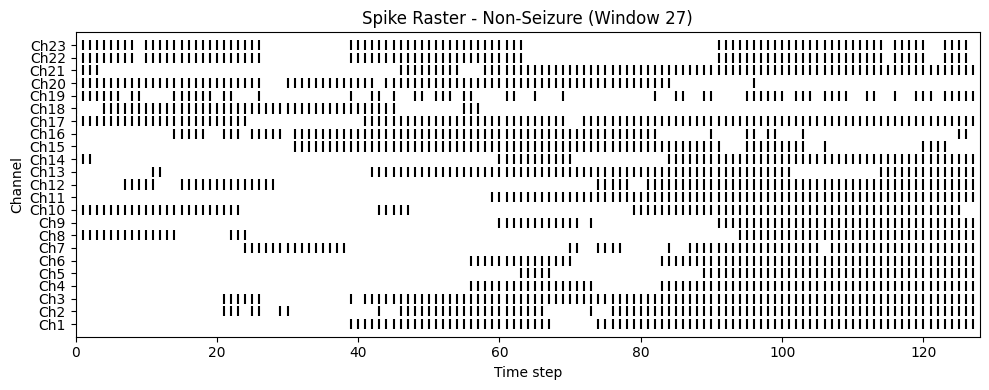

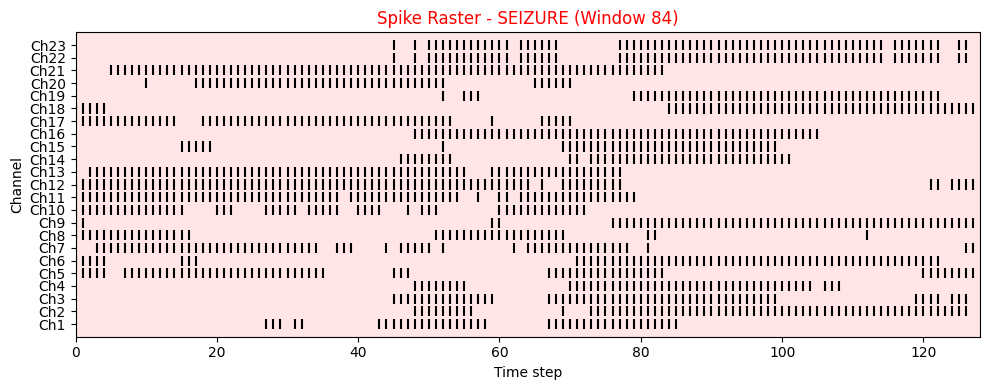

In [42]:
n=20
nidx = nonseizure_idx[n]
idx = seizure_idx[n]
plot_spike_raster_with_label(X_balanced[nidx], y_balanced[nidx], window_index=nidx)
plot_spike_raster_with_label(X_balanced[idx], y_balanced[idx], window_index=idx)


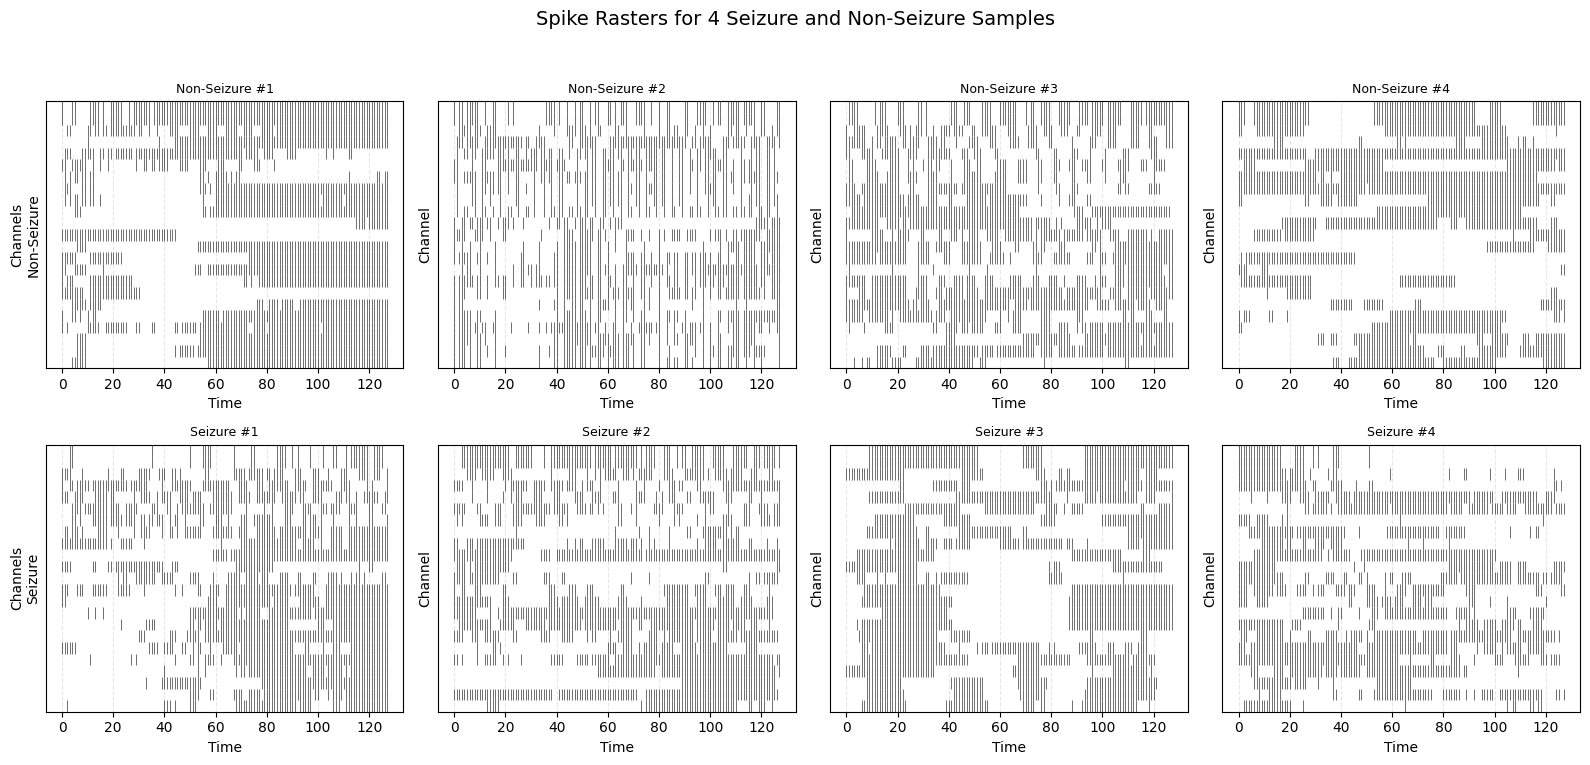

In [44]:
plot_multiple_spike_rasters(X_balanced, y_balanced, num_samples=4, figsize=(16, 8))

### Creating a SpikeDataset with Augmentations and Time-Pooling

This section defines a custom PyTorch `Dataset` class (`SpikeDataset`) that prepares spike-encoded EEG windows for training and validation. It includes optional channel dropout, temporal masking, and time pooling—three augmentations that improve robustness and efficiency in spiking neural network (SNN) models.

---

## 1. SpikeDataset Class

```python
class SpikeDataset(Dataset):
...
```
Purpose
SpikeDataset takes spike-encoded windows of shape (N, C, T) and transforms them into SNN-ready tensors of shape (T, C) while applying optional spike-domain augmentations.

Main Features
a. Input storage
python
Copy code
self.X = torch.tensor(X, dtype=torch.float32)
self.y = torch.tensor(y, dtype=torch.long)
Stores all windows and labels as tensors for efficient loading.

b. Channel Dropout (optional)
python
Copy code
if self.channel_dropout_p > 0:
    mask = (torch.rand(C) > self.channel_dropout_p).float()
    x = x * mask.view(C, 1)
Randomly zeroes out entire input channels (spike trains) to simulate missing/noisy electrodes and encourage model robustness.

c. Time Masking (optional)
python
Copy code
if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob:
    t0 = torch.randint(0, max(1, T - self.time_mask_len), (1,)).item()
    x[:, t0:t0+self.time_mask_len] = 0.0
Randomly masks short time segments to mimic transient signal dropouts, improving temporal generalisation.

d. Time Max-Pooling
python
Copy code
if self.time_pool > 1:
    Ttrim = (T // self.time_pool) * self.time_pool
    x = x[:, :Ttrim]
    x = x.view(C, -1, self.time_pool).amax(dim=2)
Reduces temporal resolution by taking the maximum spike within non-overlapping windows of length time_pool.
This reduces:

Sequence length T

Computational cost for the SNN

while retaining salient spike events.

e. Format for SNNs
python
Copy code
x = x.permute(1, 0).contiguous()    # (T, C)
SNNs expect input in time-major format, so the dataset transposes (C, T) into (T, C).

### 2. Building Training and Validation Sets
```python
X_train, X_val, y_train, y_val = train_test_split(...)
Splits the balanced dataset into:
``` 
70% training
30% validation

Stratification ensures seizure/non-seizure ratios remain consistent.

### 3. Dataset Instances with Augmentations
``` python
train_dataset = SpikeDataset(..., channel_dropout_p=0.1, time_mask_prob=0.2)
val_dataset   = SpikeDataset(..., time_pool=4)
``` 
Training dataset uses:

Channel dropout (10%)

Time masking (20% probability)

Time pooling (factor = 4)

Validation dataset uses:

Time pooling only (no augmentations)

This ensures fair evaluation with clean data, while the model learns robustness from augmented samples during training.

### 4. PyTorch DataLoaders
``` python
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)
```
train_loader shuffles samples each epoch for stochastic learning

val_loader keeps a fixed order for reproducible evaluation

Both return time-major spike sequences suitable for spiking neural network training.

In [52]:
class SpikeDataset(Dataset):
    def __init__(self, X, y, time_pool=4, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.time_pool = time_pool
        self.channel_dropout_p = channel_dropout_p
        self.time_mask_prob = time_mask_prob
        self.time_mask_len = time_mask_len

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (C, T)
        C, T = x.shape

        # ----- optional channel dropout -----
        if self.channel_dropout_p > 0:
            mask = (torch.rand(C) > self.channel_dropout_p).float()
            x = x * mask.view(C, 1)

        # ----- optional simple time masking -----
        if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob:
            t0 = torch.randint(0, max(1, T - self.time_mask_len), (1,)).item()
            x[:, t0:t0+self.time_mask_len] = 0.0

        # ----- max-pool over time (reduce T) -----
        if self.time_pool > 1:
            Ttrim = (T // self.time_pool) * self.time_pool
            x = x[:, :Ttrim]                    # (C, T')
            x = x.view(C, -1, self.time_pool).amax(dim=2)  # (C, T'/pool)

        # to (T, C) for SNN
        x = x.permute(1, 0).contiguous()  # (T, C)
        return x, self.y[idx]

# Split
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.3, stratify=y_balanced)

train_dataset = SpikeDataset(X_train, y_train, time_pool=4, channel_dropout_p=0.1, time_mask_prob=0.2, time_mask_len=4)
val_dataset   = SpikeDataset(X_val,   y_val,   time_pool=4)

# Loaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# ConvSNN-ResAttn: Residual Depthwise Conv + Temporal Attention + Spiking Head  
This section defines a **modern, stable, and high-performance ConvSNN architecture** that combines:

- Residual depthwise-separable convolutions  
- Multi-Head Self-Attention over time  
- A spiking classification head using LIF neurons  
- Stable training strategies (LayerNorm, gradient clipping, One-Cycle LR, focal loss option)

This architecture is designed for **fast, robust seizure detection** from spike-encoded EEG windows.

---

## 1. Device Setup
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
``` 
Automatically selects GPU if available.

2. Helper Function: Converting Time Constants to LIF Beta
``` python
def beta_from_tau(dt_ms, tau_ms):
    return exp(-dt / tau)
```
Converts continuous membrane time constant (tau_ms) into the discrete-time LIF decay factor β, ensuring the spiking neuron behaves according to biologically meaningful time scales.

### 3. Residual Depthwise-Separable Convolution Block (ResDSConv1D)
``` python
class ResDSConv1D(nn.Module):
    ...
``` 
A lightweight temporal feature extractor:

Depthwise conv: channel-wise temporal filtering

Pointwise conv: learns cross-channel mixing

Residual connection: preserves stability and gradient flow

BatchNorm + GELU: helps convergence on EEG signals

Optional downsampling when stride > 1

This forms the temporal backbone before attention.

### 4. Temporal Multi-Head Self-Attention (MHSA)
``` python
class TemporalMHSA(nn.Module):
    ...
``` 
Self-attention allows the model to:

Capture long-range temporal dependencies

Model non-local seizure signatures

Complement convolution’s local receptive fields

A LayerNorm-first design improves stability with small batch sizes.

### 5. ConvSNN-ResAttn Model Architecture
``` python
class ConvSNN_ResAttn(nn.Module):
    ...
``` 
Architecture Summary
Input: (T, B, C) spike window
Processing Pipeline:

Stem Conv: initial temporal feature extractor

Residual DS-Conv blocks: deepen temporal representation

Temporal MHSA: model long-range relationships across time

Spiking Head:

fc1 → LayerNorm → LIF neuron

Dropout for regularisation

fc_out → output-LIF

Outputs time-aggregated logits for classification

Spiking Stability Techniques
Learnable β membrane constant

LayerNorm instead of BatchNorm for small batches

Kaiming initialisation for all layers

Dropout inside the spiking path

These design choices greatly improve stability over naive ConvSNN implementations.

### 6. Model Instantiation
``` python
model = ConvSNN_ResAttn(...)
``` 
The model is configured with:

Input channels = EEG channels

stem_width = 64

blocks = 2 DS-Conv layers

attn_heads = 4

snn_hidden = 128

Spiking dynamics: dt = 4 ms, tau = 20 ms, slope = 12

Prints model size in millions of parameters.

### 7. Loss Function (Weighted CE + Optional Focal Loss)
``` python
criterion = nn.CrossEntropyLoss(weight=class_weights)
``` 
Weights classes inversely to their frequency to mitigate imbalance.

Optional Focal Loss is provided to further focus learning on hard seizure samples.

### 8. Optimiser, Scheduler & Gradient Clipping
``` python
optimizer = AdamW(...)
scheduler = OneCycleLR(...)
CLIP_NORM = 1.0
``` 
AdamW provides stable optimisation

OneCycleLR accelerates convergence

Gradient clipping prevents exploding gradients in spiking models

### 9. Training Loop with Early Stopping
The loop:

Runs EPOCHS = 60

Logs training accuracy, F1, and loss

Evaluates on validation set each epoch

Tracks best F1/accuracy

Uses early stopping if F1 fails to improve for 10 epochs

Why this matters:
Spiking models are more sensitive to training instability — this setup ensures smooth, controlled optimisation.

### 10. Final Output
Prints the best validation epoch with its accuracy and F1-score, giving a clear summary of model performance.

In [70]:
# =========================
# Clean ConvSNN (Res + Attn) + Stable Training Setup
# =========================
# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Helpers ----
def beta_from_tau(dt_ms: float, tau_ms: float) -> float:
    dt = max(1e-6, float(dt_ms))
    tau = max(1e-6, float(tau_ms))
    return float(np.exp(-dt / tau))

class ResDSConv1D(nn.Module):
    """Residual depthwise-separable temporal conv."""
    def __init__(self, c_in, c_out, ksize=9, stride=1, drop=0.1):
        super().__init__()
        pad = ksize // 2
        self.dw = nn.Conv1d(c_in, c_in, ksize, stride=stride, padding=pad, groups=c_in, bias=False)
        self.bn1 = nn.BatchNorm1d(c_in, eps=1e-4, momentum=0.1)
        self.pw = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
        self.drop = nn.Dropout(drop)
        self.act  = nn.GELU()
        self.down = None
        if stride != 1 or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv1d(c_in, c_out, 1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
            )
    def forward(self, x):           # (B, C_in, T)
        y = self.dw(x)
        y = self.bn1(y)
        y = self.act(y)
        y = self.pw(y)
        y = self.bn2(y)
        y = self.drop(y)
        s = x if self.down is None else self.down(x)
        return self.act(y + s)      # (B, C_out, T')

class TemporalMHSA(nn.Module):
    """Temporal Multi-Head Self-Attention."""
    def __init__(self, channels, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=attn_drop, batch_first=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.norm = nn.LayerNorm(channels)
    def forward(self, x_bct):        # (B, C, T)
        B, C, T = x_bct.shape
        x_btc = x_bct.transpose(1, 2).contiguous()  # (B, T, C)
        x_norm = self.norm(x_btc)
        out, _ = self.mha(x_norm, x_norm, x_norm, need_weights=False)
        out = self.proj_drop(out)
        out = out + x_btc
        return out.transpose(1, 2).contiguous()     # (B, C, T)

class ConvSNN_ResAttn(nn.Module):
    """
    ConvSNN with residual DS-Conv front-end + temporal MHSA + spiking head.
    Returns time-aggregated logits for CE/Focal.
    """
    def __init__(
        self,
        n_inputs: int,
        n_outputs: int,
        *,
        stem_width: int = 64,
        blocks: int = 2,
        ksize: int = 9,
        strides: tuple = (1, 1),     # safer if dataset already time-pools
        attn_heads: int = 4,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        snn_hidden: int = 128,
        dt_ms: float = 4.0,
        tau_ms: float = 20.0,
        dropout: float = 0.20,
        slope: float = 12.0,
        learn_beta: bool = True
    ):
        super().__init__()
        beta = beta_from_tau(dt_ms, tau_ms)

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_inputs, stem_width, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_width, eps=1e-4, momentum=0.1),
            nn.GELU()
        )
        # Residual temporal blocks
        _strides = list(strides) + [1] * max(0, blocks - len(strides))
        feats = []
        c_in = stem_width
        for b in range(blocks):
            feats.append(ResDSConv1D(c_in, stem_width, ksize=ksize, stride=_strides[b], drop=0.1))
            c_in = stem_width
        self.feats = nn.Sequential(*feats)

        # Temporal attention
        self.attn = TemporalMHSA(stem_width, num_heads=attn_heads, attn_drop=attn_drop, proj_drop=proj_drop)

        # Spiking head (use LayerNorm for small batch stability)
        self.fc1  = nn.Linear(stem_width, snn_hidden)
        self.ln1  = nn.LayerNorm(snn_hidden)  # swapped from BN
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)

        self.fc_out  = nn.Linear(snn_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)

        # Init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):        # (T, B, C_in)
        # Conv over time in one shot
        x_bct = x_tm.permute(1, 2, 0).contiguous()   # (B, C, T)
        feat = self.stem(x_bct)                      # (B, W, T)
        feat = self.feats(feat)                      # (B, W, T')
        feat = self.attn(feat)                       # (B, W, T')

        # Spiking head per timestep
        B, W, Tprime = feat.shape
        dev = x_tm.device
        feat_tbc = feat.permute(2, 0, 1).contiguous()  # (T', B, W)

        mem1 = torch.zeros(B, self.fc1.out_features, device=dev)
        memo = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(Tprime):
            ft = feat_tbc[t]                 # (B, W)
            h1 = self.fc1(ft)
            h1 = self.ln1(h1)               # LN instead of BN
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)

            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / Tprime           # (B, n_outputs) logits

# ---- Instantiate model ----
# Expect X_train with shape (N, C, T)
C_in = X_train.shape[1]
model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=64, blocks=2, ksize=9, strides=(1,1),
    attn_heads=4, attn_drop=0.0, proj_drop=0.0,
    snn_hidden=128, dt_ms=4.0, tau_ms=20.0, dropout=0.20, slope=12.0, learn_beta=True
).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ---- Loss (start with weighted CE; switch to Focal later if needed) ----
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = max(counts) if len(counts) else 1
# assumes classes are 0..K-1; adjust if needed
num_classes = int(max(unique)) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---- Optional Focal Loss (toggle by uncommenting) ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction='none')
        pt = torch.exp(-ce)
        loss = self.alpha * (1 - pt) ** self.gamma * ce
        return loss.mean() if self.reduction == "mean" else loss.sum()
# criterion = FocalLoss(alpha=0.25, gamma=2.0)  # <-- enable carefully after stabilising

# ---- Optimiser / Scheduler / Clip ----
EPOCHS = 60
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.25
)
CLIP_NORM = 1.0

# ---- Train loop (unchanged logic) ----
best_val_acc = 0.0
best_val_f1  = 0.0
best_epoch   = 0
last_val_f1  = 0.0
epochs_no_improve = 0
patience = 10
min_improvement = 1e-4

for epoch in range(EPOCHS):
    model.train()
    total_loss, all_preds, all_targets = 0.0, [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)    # xb: (B, T, C)
        xb = xb.permute(1, 0, 2).contiguous()    # -> (T, B, C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                       # (B, 2)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * yb.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().numpy())
        all_targets.extend(yb.detach().cpu().numpy())

    train_acc = accuracy_score(all_targets, all_preds)
    train_f1  = f1_score(all_targets, all_preds)
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # ---- Validation
    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * yb.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_f1  = f1_score(val_targets, val_preds)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"           Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    improved = False
    if (val_f1 - best_val_f1) > min_improvement or (abs(val_f1 - best_val_f1) <= min_improvement and val_acc > best_val_acc):
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        improved = True

    if (val_f1 - last_val_f1) <= min_improvement and not improved:
        epochs_no_improve += 1
        print(f"No >{min_improvement*100:.4f}% F1 improvement | Count: {epochs_no_improve}/{patience}")
    else:
        epochs_no_improve = 0

    last_val_f1 = val_f1
    if epochs_no_improve >= patience:
        print(f"Early stopping: No >{min_improvement*100:.4f}% F1 improvement for {patience} epochs.")
        break

print(f"\nBest Validation Results: Epoch {best_epoch:02d} | Acc: {best_val_acc:.4f} | F1: {best_val_f1:.4f}")


Using device: cpu
Params (M): 0.040004
Epoch 01 | Train Loss: 0.6460 | Acc: 0.6143 | F1: 0.4946
           Val Loss: 0.5938 | Acc: 0.8361 | F1: 0.5243
Epoch 02 | Train Loss: 0.5261 | Acc: 0.7801 | F1: 0.6125
           Val Loss: 0.5265 | Acc: 0.8617 | F1: 0.6495
Epoch 03 | Train Loss: 0.4913 | Acc: 0.8018 | F1: 0.6411
           Val Loss: 0.4948 | Acc: 0.8659 | F1: 0.6728
Epoch 04 | Train Loss: 0.4579 | Acc: 0.8263 | F1: 0.6717
           Val Loss: 0.4514 | Acc: 0.8724 | F1: 0.7140
Epoch 05 | Train Loss: 0.4304 | Acc: 0.8420 | F1: 0.6994
           Val Loss: 0.4112 | Acc: 0.8747 | F1: 0.7360
Epoch 06 | Train Loss: 0.4093 | Acc: 0.8556 | F1: 0.7208
           Val Loss: 0.3841 | Acc: 0.8816 | F1: 0.7569
Epoch 07 | Train Loss: 0.3862 | Acc: 0.8666 | F1: 0.7406
           Val Loss: 0.3715 | Acc: 0.8840 | F1: 0.7664
Epoch 08 | Train Loss: 0.3695 | Acc: 0.8750 | F1: 0.7563
           Val Loss: 0.3613 | Acc: 0.8691 | F1: 0.7546
No >0.0100% F1 improvement | Count: 1/10
Epoch 09 | Train Loss: 0

### What’s New in This ConvSNN Pipeline Compared to the Previous Version?

This notebook cell implements an **extended ConvSNN pipeline** that builds on the earlier ConvSNN-ResAttn model, but adds several important enhancements in **input encoding, model capacity, data handling, and decision thresholding**.

Below is a summary of **key differences** from the earlier code.

---

## 1. Dual-Path Input: Optional Latency Encoding

**New in this version:**

- Adds an **optional second spike encoding** per channel using *latency coding*:
```python
  USE_LATENCY_ENCODING = True
  LATENCY_THR = 1.0
```

latency_encode_batch creates a spike at the first time index where the z-scored signal crosses a threshold.

If enabled, the input becomes:
``` python
X_input = np.concatenate([X_balanced, X_lat], axis=1)  # (N, 2C, T)
```

So, unlike the previous code (which used a single spike representation), this pipeline can stack two encodings per channel (e.g., rate/sigma-delta style + latency), giving the ConvSNN richer temporal features.

### 2. Modified SpikeDataset and Time Pooling

Differences vs the earlier SpikeDataset:

Default time pooling reduced:

TIME_POOL = 2  # was 4


This keeps finer temporal resolution for the ConvSNN, at the cost of slightly longer sequences.

Dataset API includes a train flag:

``` python
SpikeDataset(..., train=True/False)
``` 

Training set: uses channel dropout and time masking.

Validation set: those augmentations are disabled (only time pooling).

This makes the augmentation behaviour explicit and more controlled than before.

### 3. Wider ConvSNN-ResAttn Model

The ConvSNN architecture is similar in structure to the previous version (stem → residual depthwise conv blocks → temporal MHSA → spiking head), but capacity is increased:

``` python
stem_width increased from 64 → 96

snn_hidden increased from 128 → 192

model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=96,
    snn_hidden=192,
    ...
)
``` 

So this version uses a wider feature space and larger spiking head, better matching the richer input (especially when latency encoding is enabled).

### 4. Slightly Different Optimisation Hyperparameters

The training setup is conceptually similar (AdamW + OneCycleLR + gradient clipping), but with extended training and tuned LR schedule:
``` python
EPOCHS = 100 (previous example used 60 epochs)
MAX_LR = 8e-4, WEIGHT_DECAY = 1e-4
```
OneCycleLR configured with epochs=EPOCHS and pct_start=0.3

This allows more training time and a slightly different learning rate schedule tuned for the new input and model size.

### 5. Adjusted Class Weights and Focal Loss Option

Class weighting now includes a deliberate bump for the seizure class:
``` python
if num_classes >= 2:
    weights[1] = weights[1] * 1.2
``` 

An optional mild FocalLoss is also included (commented out), with parameters slightly tweaked from the earlier version (e.g., alpha=0.30, gamma=1.5) to emphasise under-called seizures if needed.

### 6. Threshold Tuning After Training (New Post-Hoc Calibration Stage)

The most important new component:

After training with standard argmax decision, the code runs a post-hoc threshold sweep on the validation set:
``` python 
VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)
``` 

It:

Collects validation logits.

Converts them to seizure probabilities P(seizure).

Sweeps thresholds τ from 0.20 to 0.80.

For each τ, computes F1 and accuracy.

Selects the τ that maximises F1 (tie-broken by accuracy).

This is new compared to the previous code, which used the default decision boundary (argmax / τ=0.5). Here, we explicitly calibrate the operating point to better trade off sensitivity and specificity for seizure detection.

In [71]:
# ============================
# EEG Seizure ConvSNN Full Pipeline with Threshold Tuning
# ============================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import snntorch as snn
from snntorch import surrogate

# ----------------------------
# Config
# ----------------------------
BATCH_SIZE   = 64
EPOCHS       = 100
MAX_LR       = 8e-4
WEIGHT_DECAY = 1e-4
CLIP_NORM    = 1.0
TIME_POOL    = 2               # reduced (was 4)
USE_LATENCY_ENCODING = True    # stack latency-coded spikes as an extra encoding
LATENCY_THR  = 1.0             # latency threshold (on z-scored inputs)
VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)  # min, max, step

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Optional second encoding: latency-coded spike channel per EEG channel
# ----------------------------
def latency_encode_window(chx: np.ndarray, thr: float=1.0) -> np.ndarray:
    """Return one-hot spike at first time exceeding threshold; else all zeros."""
    idx = np.argmax(chx > thr)
    out = np.zeros_like(chx, dtype=np.float32)
    if chx[idx] > thr:
        out[idx] = 1.0
    return out

def latency_encode_batch(X_ncT: np.ndarray, thr: float=1.0) -> np.ndarray:
    """Apply latency encoding channel-wise: input (N,C,T) -> (N,C,T) (0/1 spikes)."""
    N, C, T = X_ncT.shape
    out = np.zeros_like(X_ncT, dtype=np.float32)
    for n in range(N):
        for c in range(C):
            out[n, c] = latency_encode_window(X_ncT[n, c], thr)
    return out

# ----------------------------
# Build inputs (stack encodings if enabled)
# ----------------------------
try:
    X_balanced, y_balanced
except NameError:
    raise RuntimeError("Please define X_balanced (N,C,T) and y_balanced (N,) before running.")

if USE_LATENCY_ENCODING:
    print("Building latency-coded spikes...")
    X_lat = latency_encode_batch(X_balanced, thr=LATENCY_THR)       # (N,C,T)
    X_input = np.concatenate([X_balanced, X_lat], axis=1)           # (N,2C,T)
else:
    X_input = X_balanced

N, C_in_total, T_len = X_input.shape
print(f"Input shape: {X_input.shape} (N,C,T)")

# ----------------------------
# Dataset with time pooling & light augmentation
# ----------------------------
class SpikeDataset(Dataset):
    def __init__(self, X, y, time_pool=2, channel_dropout_p=0.1, time_mask_prob=0.1, time_mask_len=4, train=True):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.time_pool = time_pool
        self.channel_dropout_p = channel_dropout_p if train else 0.0
        self.time_mask_prob = time_mask_prob if train else 0.0
        self.time_mask_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (C, T)
        y = self.y[idx]
        C, T = x.shape

        # Channel dropout
        if self.channel_dropout_p > 0:
            mask = (torch.rand(C) > self.channel_dropout_p).float()
            x = x * mask.view(C, 1)

        # Time mask
        if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob and T > self.time_mask_len:
            t0 = torch.randint(0, T - self.time_mask_len + 1, (1,)).item()
            x[:, t0:t0+self.time_mask_len] = 0.0

        # Max-pool over time
        if self.time_pool > 1:
            Ttrim = (T // self.time_pool) * self.time_pool
            x = x[:, :Ttrim]  # (C, T')
            x = x.view(C, -1, self.time_pool).amax(dim=2)  # (C, T'/pool)

        # to (T, C) for SNN
        x = x.permute(1, 0).contiguous()  # (T, C)
        return x, y

# ----------------------------
# Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_input, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Train seizure ratio:", float(np.mean(y_train)), "Val seizure ratio:", float(np.mean(y_val)))

train_ds = SpikeDataset(X_train, y_train, time_pool=TIME_POOL, channel_dropout_p=0.1, time_mask_prob=0.1, time_mask_len=4, train=True)
val_ds   = SpikeDataset(X_val,   y_val,   time_pool=TIME_POOL, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=0, train=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ----------------------------
# ConvSNN (Residual + Temporal Attention) with LN in SNN head
# ----------------------------
def beta_from_tau(dt_ms: float, tau_ms: float) -> float:
    dt = max(1e-6, float(dt_ms))
    tau = max(1e-6, float(tau_ms))
    return float(np.exp(-dt / tau))

class ResDSConv1D(nn.Module):
    def __init__(self, c_in, c_out, ksize=9, stride=1, drop=0.1):
        super().__init__()
        pad = ksize // 2
        self.dw = nn.Conv1d(c_in, c_in, ksize, stride=stride, padding=pad, groups=c_in, bias=False)
        self.bn1 = nn.BatchNorm1d(c_in, eps=1e-4, momentum=0.1)
        self.pw = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
        self.drop = nn.Dropout(drop)
        self.act  = nn.GELU()
        self.down = None
        if stride != 1 or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv1d(c_in, c_out, 1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
            )
    def forward(self, x):
        y = self.dw(x); y = self.bn1(y); y = self.act(y)
        y = self.pw(y); y = self.bn2(y); y = self.drop(y)
        s = x if self.down is None else self.down(x)
        return self.act(y + s)

class TemporalMHSA(nn.Module):
    def __init__(self, channels, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=attn_drop, batch_first=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.norm = nn.LayerNorm(channels)
    def forward(self, x_bct):  # (B,C,T)
        B, C, T = x_bct.shape
        x_btc = x_bct.transpose(1, 2).contiguous()  # (B,T,C)
        x_norm = self.norm(x_btc)
        out, _ = self.mha(x_norm, x_norm, x_norm, need_weights=False)
        out = self.proj_drop(out)
        out = out + x_btc
        return out.transpose(1, 2).contiguous()     # (B,C,T)

class ConvSNN_ResAttn(nn.Module):
    def __init__(self, n_inputs, n_outputs, *,
                 stem_width=96, blocks=2, ksize=9, strides=(1,1),
                 attn_heads=4, attn_drop=0.0, proj_drop=0.0,
                 snn_hidden=192, dt_ms=4.0, tau_ms=20.0, dropout=0.20,
                 slope=12.0, learn_beta=True):
        super().__init__()
        beta = beta_from_tau(dt_ms, tau_ms)
        # stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_inputs, stem_width, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_width, eps=1e-4, momentum=0.1),
            nn.GELU()
        )
        # residual temporal blocks
        _strides = list(strides) + [1] * max(0, blocks - len(strides))
        feats = []
        c_in = stem_width
        for b in range(blocks):
            feats.append(ResDSConv1D(c_in, stem_width, ksize=ksize, stride=_strides[b], drop=0.1))
            c_in = stem_width
        self.feats = nn.Sequential(*feats)
        # attention
        self.attn = TemporalMHSA(stem_width, num_heads=attn_heads, attn_drop=attn_drop, proj_drop=proj_drop)
        # spiking head (LayerNorm for small-batch stability)
        self.fc1  = nn.Linear(stem_width, snn_hidden)
        self.ln1  = nn.LayerNorm(snn_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)
        self.fc_out  = nn.Linear(snn_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):     # (T,B,C)
        x_bct = x_tm.permute(1, 2, 0).contiguous()  # (B,C,T)
        feat = self.stem(x_bct)
        feat = self.feats(feat)
        feat = self.attn(feat)
        B, W, Tprime = feat.shape
        dev = x_tm.device
        feat_tbc = feat.permute(2, 0, 1).contiguous()  # (T',B,W)

        mem1 = torch.zeros(B, self.fc1.out_features, device=dev)
        memo = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(Tprime):
            ft = feat_tbc[t]
            h1 = self.fc1(ft)
            h1 = self.ln1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)

            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / Tprime  # logits (B, n_outputs)

# ----------------------------
# Instantiate model
# ----------------------------
C_in = X_train.shape[1]  # channels (after stacking encodings if enabled)
model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=96, blocks=2, ksize=9, strides=(1,1),
    attn_heads=4, attn_drop=0.0, proj_drop=0.0,
    snn_hidden=192, dt_ms=4.0, tau_ms=20.0, dropout=0.20, slope=12.0, learn_beta=True
).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ----------------------------
# Loss: weighted CE (stable). Mild Focal toggle available.
# ----------------------------
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = max(counts) if len(counts) else 1
num_classes = int(max(unique)) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
# Slight bump to seizure class if it's class 1
if num_classes >= 2: weights[1] = weights[1] * 1.2
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# # Optional: mild FocalLoss (enable if F1 under-calls seizures)
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.30, gamma=1.5, reduction="mean"):
#         super().__init__()
#         self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
#     def forward(self, logits, target):
#         ce = F.cross_entropy(logits, target, reduction='none')
#         pt = torch.exp(-ce)
#         loss = self.alpha * (1-pt)**self.gamma * ce
#         return loss.mean() if self.reduction=="mean" else loss.sum()
# criterion = FocalLoss(alpha=0.30, gamma=1.5)

# ----------------------------
# Optim / Scheduler
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.3
)

# ----------------------------
# Training with early stop on F1
# ----------------------------
best_val_acc = 0.0
best_val_f1  = 0.0
best_epoch   = 0
last_val_f1  = 0.0
epochs_no_improve = 0
patience = 10
min_improvement = 1e-4

for epoch in range(EPOCHS):
    model.train()
    total_loss, all_preds, all_targets = 0.0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)       # xb: (B,T,C)
        xb = xb.permute(1, 0, 2).contiguous()       # -> (T,B,C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                          # (B,2)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * yb.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().numpy())
        all_targets.extend(yb.detach().cpu().numpy())

    train_acc = accuracy_score(all_targets, all_preds)
    train_f1  = f1_score(all_targets, all_preds)
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # ---- Validation
    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * yb.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_f1  = f1_score(val_targets, val_preds)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"           Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    improved = False
    if (val_f1 - best_val_f1) > min_improvement or (abs(val_f1 - best_val_f1) <= min_improvement and val_acc > best_val_acc):
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        improved = True

    if (val_f1 - last_val_f1) <= min_improvement and not improved:
        epochs_no_improve += 1
        print(f"No >{min_improvement*100:.4f}% F1 improvement | Count: {epochs_no_improve}/{patience}")
    else:
        epochs_no_improve = 0

    last_val_f1 = val_f1
    if epochs_no_improve >= patience:
        print(f"Early stopping: No >{min_improvement*100:.4f}% F1 improvement for {patience} epochs.")
        break

print(f"\nBest Validation (argmax): Epoch {best_epoch:02d} | Acc: {best_val_acc:.4f} | F1: {best_val_f1:.4f}")

# ----------------------------
# Post-hoc threshold sweep on validation
# ----------------------------
model.eval()
val_logits_all, val_y_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).permute(1,0,2).contiguous()
        logits = model(xb)
        val_logits_all.append(logits.cpu())
        val_y_all.append(yb)

val_logits_all = torch.cat(val_logits_all, 0).numpy()
val_y_all = torch.cat(val_y_all, 0).numpy()

probs = torch.softmax(torch.tensor(val_logits_all), dim=1).numpy()[:,1]  # P(seizure)
t_min, t_max, t_step = VAL_THRESH_SWEEP
taus = np.arange(t_min, t_max + 1e-9, t_step)

best_tau, best_f1, best_acc = 0.5, 0.0, 0.0
for t in taus:
    pred = (probs >= t).astype(int)
    f1  = f1_score(val_y_all, pred)
    acc = accuracy_score(val_y_all, pred)
    if f1 > best_f1 or (abs(f1 - best_f1) <= 1e-8 and acc > best_acc):
        best_tau, best_f1, best_acc = float(t), float(f1), float(acc)

print(f"\nPost-hoc threshold sweep on VAL:")
print(f"Chosen τ = {best_tau:.2f} | Val F1={best_f1:.3f} | Val Acc={best_acc:.3f}")

# Example: how to use best_tau at inference
# y_pred = (softmax(logits)[:,1] >= best_tau).int()


Using device: cpu
Building latency-coded spikes...
Input shape: (23908, 46, 128) (N,C,T)
Train seizure ratio: 0.2500149387511204 Val seizure ratio: 0.24996514707932524
Params (M): 0.091204
Epoch 01 | Train Loss: 0.6587 | Acc: 0.4554 | F1: 0.4368
           Val Loss: 0.5800 | Acc: 0.8671 | F1: 0.6872
Epoch 02 | Train Loss: 0.5092 | Acc: 0.7637 | F1: 0.6158
           Val Loss: 0.4383 | Acc: 0.8374 | F1: 0.6989
Epoch 03 | Train Loss: 0.4349 | Acc: 0.8195 | F1: 0.6826
           Val Loss: 0.4167 | Acc: 0.8494 | F1: 0.7152
Epoch 04 | Train Loss: 0.4038 | Acc: 0.8386 | F1: 0.7099
           Val Loss: 0.3849 | Acc: 0.8547 | F1: 0.7331
Epoch 05 | Train Loss: 0.3800 | Acc: 0.8499 | F1: 0.7310
           Val Loss: 0.3629 | Acc: 0.8673 | F1: 0.7534
Epoch 06 | Train Loss: 0.3556 | Acc: 0.8676 | F1: 0.7560
           Val Loss: 0.3573 | Acc: 0.8632 | F1: 0.7532
No >0.0100% F1 improvement | Count: 1/10
Epoch 07 | Train Loss: 0.3416 | Acc: 0.8752 | F1: 0.7687
           Val Loss: 0.3388 | Acc: 0.8957

In [74]:
# ===========================================
# EEG Seizure ConvSNN: Smoothing + Calibration + Threshold Sweep
# ===========================================

# ----------------------------
# Config
# ----------------------------
BATCH_SIZE   = 64
EPOCHS       = 100
MAX_LR       = 8e-4
WEIGHT_DECAY = 2e-4
CLIP_NORM    = 1.0

TIME_POOL    = 2               # keep more temporal detail
CH_DROP_P    = 0.15            # channel dropout (train)
TIME_MASK_P  = 0.15            # simple time masking (train)
TIME_MASK_LEN= 4

USE_LATENCY_ENCODING = True    # stack latency-coded spikes
LATENCY_THR  = 1.0             # threshold for latency encoding

VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)  # min, max, step

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Expect X_balanced (N,C,T), y_balanced (N,)
# ----------------------------
try:
    X_balanced, y_balanced
except NameError:
    raise RuntimeError("Please define X_balanced (N,C,T) and y_balanced (N,) before running.")

# ----------------------------
# Optional: add a latency-coded spike stream and stack with current spikes
# ----------------------------
def latency_encode_window(chx: np.ndarray, thr: float=1.0) -> np.ndarray:
    idx = np.argmax(chx > thr)
    out = np.zeros_like(chx, dtype=np.float32)
    if chx[idx] > thr:
        out[idx] = 1.0
    return out

def latency_encode_batch(X_ncT: np.ndarray, thr: float=1.0) -> np.ndarray:
    N, C, T = X_ncT.shape
    out = np.zeros_like(X_ncT, dtype=np.float32)
    for n in range(N):
        for c in range(C):
            out[n, c] = latency_encode_window(X_ncT[n, c], thr)
    return out

if USE_LATENCY_ENCODING:
    print("Building latency-coded spikes...")
    X_lat = latency_encode_batch(X_balanced, thr=LATENCY_THR)   # (N,C,T)
    X_input = np.concatenate([X_balanced, X_lat], axis=1)       # (N,2C,T)
else:
    X_input = X_balanced

N, C_in_total, T_len = X_input.shape
print(f"Input shape: {X_input.shape} (N,C,T)")

# ----------------------------
# Dataset with time pooling & light augmentation
# ----------------------------
class SpikeDataset(Dataset):
    def __init__(self, X, y, time_pool=2, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4, train=True):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.time_pool = time_pool
        self.channel_dropout_p = channel_dropout_p if train else 0.0
        self.time_mask_prob = time_mask_prob if train else 0.0
        self.time_mask_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (C, T)
        y = self.y[idx]
        C, T = x.shape

        # Channel dropout
        if self.channel_dropout_p > 0:
            mask = (torch.rand(C) > self.channel_dropout_p).float()
            x = x * mask.view(C, 1)

        # Time mask
        if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob and T > self.time_mask_len:
            t0 = torch.randint(0, T - self.time_mask_len + 1, (1,)).item()
            x[:, t0:t0+self.time_mask_len] = 0.0

        # Max-pool over time
        if self.time_pool > 1:
            Ttrim = (T // self.time_pool) * self.time_pool
            x = x[:, :Ttrim]
            x = x.view(C, -1, self.time_pool).amax(dim=2)  # (C, T/time_pool)

        # to (T, C) for SNN
        x = x.permute(1, 0).contiguous()  # (T, C)
        return x, y

# ----------------------------
# Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_input, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Train seizure ratio:", float(np.mean(y_train)), "Val seizure ratio:", float(np.mean(y_val)))

train_ds = SpikeDataset(X_train, y_train, time_pool=TIME_POOL, channel_dropout_p=CH_DROP_P, time_mask_prob=TIME_MASK_P, time_mask_len=TIME_MASK_LEN, train=True)
val_ds   = SpikeDataset(X_val,   y_val,   time_pool=TIME_POOL, channel_dropout_p=0.0,       time_mask_prob=0.0,      time_mask_len=0,             train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ----------------------------
# ConvSNN (Residual + Temporal Attention) with LN in SNN head
# ----------------------------
def beta_from_tau(dt_ms: float, tau_ms: float) -> float:
    dt = max(1e-6, float(dt_ms))
    tau = max(1e-6, float(tau_ms))
    return float(np.exp(-dt / tau))

class ResDSConv1D(nn.Module):
    def __init__(self, c_in, c_out, ksize=9, stride=1, drop=0.1):
        super().__init__()
        pad = ksize // 2
        self.dw = nn.Conv1d(c_in, c_in, ksize, stride=stride, padding=pad, groups=c_in, bias=False)
        self.bn1 = nn.BatchNorm1d(c_in, eps=1e-4, momentum=0.1)
        self.pw = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
        self.drop = nn.Dropout(drop)
        self.act  = nn.GELU()
        self.down = None
        if stride != 1 or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv1d(c_in, c_out, 1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
            )
    def forward(self, x):  # (B,C_in,T)
        y = self.dw(x); y = self.bn1(y); y = self.act(y)
        y = self.pw(y); y = self.bn2(y); y = self.drop(y)
        s = x if self.down is None else self.down(x)
        return self.act(y + s)  # (B,C_out,T')

class TemporalMHSA(nn.Module):
    def __init__(self, channels, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=attn_drop, batch_first=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.norm = nn.LayerNorm(channels)
    def forward(self, x_bct):  # (B,C,T)
        B, C, T = x_bct.shape
        x_btc = x_bct.transpose(1, 2).contiguous()  # (B,T,C)
        x_norm = self.norm(x_btc)
        out, _ = self.mha(x_norm, x_norm, x_norm, need_weights=False)
        out = self.proj_drop(out)
        out = out + x_btc
        return out.transpose(1, 2).contiguous()     # (B,C,T)

class ConvSNN_ResAttn(nn.Module):
    def __init__(self, n_inputs, n_outputs, *,
                 stem_width=96, blocks=2, ksize=9, strides=(1,1),
                 attn_heads=4, attn_drop=0.0, proj_drop=0.0,
                 snn_hidden=192, dt_ms=4.0, tau_ms=20.0, dropout=0.20,
                 slope=12.0, learn_beta=True):
        super().__init__()
        beta = beta_from_tau(dt_ms, tau_ms)
        # stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_inputs, stem_width, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_width, eps=1e-4, momentum=0.1),
            nn.GELU()
        )
        # residual temporal blocks
        _strides = list(strides) + [1] * max(0, blocks - len(strides))
        feats, c_in = [], stem_width
        for b in range(blocks):
            feats.append(ResDSConv1D(c_in, stem_width, ksize=ksize, stride=_strides[b], drop=0.1))
            c_in = stem_width
        self.feats = nn.Sequential(*feats)
        # attention
        self.attn = TemporalMHSA(stem_width, num_heads=attn_heads, attn_drop=attn_drop, proj_drop=proj_drop)
        # spiking head (LayerNorm for small-batch stability)
        self.fc1  = nn.Linear(stem_width, snn_hidden)
        self.ln1  = nn.LayerNorm(snn_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)
        self.fc_out  = nn.Linear(snn_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):     # (T,B,C)
        x_bct = x_tm.permute(1, 2, 0).contiguous()  # (B,C,T)
        feat = self.stem(x_bct)
        feat = self.feats(feat)
        feat = self.attn(feat)
        B, W, Tprime = feat.shape
        dev = x_tm.device
        feat_tbc = feat.permute(2, 0, 1).contiguous()  # (T',B,W)

        mem1 = torch.zeros(B, self.fc1.out_features, device=dev)
        memo = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(Tprime):
            ft = feat_tbc[t]
            h1 = self.fc1(ft)
            h1 = self.ln1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)

            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / Tprime  # logits (B, n_outputs)

# ----------------------------
# Instantiate model
# ----------------------------
C_in = X_train.shape[1]  # channels (after stack if enabled)
model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=96, blocks=2, ksize=9, strides=(1,1),
    attn_heads=4, attn_drop=0.0, proj_drop=0.0,
    snn_hidden=192, dt_ms=4.0, tau_ms=20.0, dropout=0.20, slope=12.0, learn_beta=True
).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ----------------------------
# Loss: weighted CE + label smoothing (stable)
# ----------------------------
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = max(counts) if len(counts) else 1
num_classes = int(max(unique)) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
if num_classes >= 2:
    weights[1] *= 1.2   # gently emphasize seizure class
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

# # Optional mild Focal if needed later:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.30, gamma=1.5, reduction="mean"):
#         super().__init__()
#         self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
#     def forward(self, logits, target):
#         ce = F.cross_entropy(logits, target, reduction='none')
#         pt = torch.exp(-ce)
#         loss = self.alpha * (1-pt)**self.gamma * ce
#         return loss.mean() if self.reduction=="mean" else loss.sum()
# criterion = FocalLoss(alpha=0.30, gamma=1.5)

# ----------------------------
# Optim / Scheduler
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.3
)

# ----------------------------
# Train with early stop on F1
# ----------------------------
best_val_acc = 0.0
best_val_f1  = 0.0
best_epoch   = 0
last_val_f1  = 0.0
epochs_no_improve = 0
patience = 10
min_improvement = 1e-4

for epoch in range(EPOCHS):
    model.train()
    total_loss, all_preds, all_targets = 0.0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)       # xb: (B,T,C)
        xb = xb.permute(1, 0, 2).contiguous()       # -> (T,B,C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                          # (B,2)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * yb.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().numpy())
        all_targets.extend(yb.detach().cpu().numpy())

    train_acc = accuracy_score(all_targets, all_preds)
    train_f1  = f1_score(all_targets, all_preds)
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # ---- Validation
    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * yb.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_f1  = f1_score(val_targets, val_preds)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"           Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    improved = False
    if (val_f1 - best_val_f1) > min_improvement or (abs(val_f1 - best_val_f1) <= min_improvement and val_acc > best_val_acc):
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        improved = True

    if (val_f1 - last_val_f1) <= min_improvement and not improved:
        epochs_no_improve += 1
        print(f"No >{min_improvement*100:.4f}% F1 improvement | Count: {epochs_no_improve}/{patience}")
    else:
        epochs_no_improve = 0

    last_val_f1 = val_f1
    if epochs_no_improve >= patience:
        print(f"Early stopping: No >{min_improvement*100:.4f}% F1 improvement for {patience} epochs.")
        break

print(f"\nBest Validation (argmax): Epoch {best_epoch:02d} | Acc: {best_val_acc:.4f} | F1: {best_val_f1:.4f}")

# ----------------------------
# Temperature scaling (calibration) on validation logits
# ----------------------------
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_temp = nn.Parameter(torch.zeros(1))  # T=1 init
    def forward(self, logits):
        T = self.log_temp.exp()
        return logits / T

def fit_temperature(model, val_loader, device):
    model.eval()
    scaler = TemperatureScaler().to(device)
    opt = torch.optim.LBFGS(scaler.parameters(), lr=0.1, max_iter=50)

    # collect val logits/targets
    all_logits, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).permute(1,0,2).contiguous()
            logits = model(xb)
            all_logits.append(logits.detach())
            all_tgts.append(yb.to(device))
    all_logits = torch.cat(all_logits, 0)
    all_tgts   = torch.cat(all_tgts,   0)

    nll = nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad()
        loss = nll(scaler(all_logits), all_tgts)
        loss.backward()
        return loss

    opt.step(closure)
    with torch.no_grad():
        T = scaler.log_temp.exp().item()
    print(f"Calibrated temperature T = {T:.3f}")
    return scaler

scaler = fit_temperature(model, val_loader, device)

# ----------------------------
# Post-hoc threshold sweep (on CALIBRATED probabilities)
# ----------------------------
model.eval()
val_logits_all, val_y_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).permute(1,0,2).contiguous()
        logits = model(xb)
        logits = scaler(logits)  # calibrated logits
        val_logits_all.append(logits.cpu())
        val_y_all.append(yb)

val_logits_all = torch.cat(val_logits_all, 0).numpy()
val_y_all = torch.cat(val_y_all, 0).numpy()

probs = torch.softmax(torch.tensor(val_logits_all), dim=1).numpy()[:,1]  # P(seizure)
t_min, t_max, t_step = VAL_THRESH_SWEEP
taus = np.arange(t_min, t_max + 1e-9, t_step)

best_tau, best_f1, best_acc = 0.5, 0.0, 0.0
for t in taus:
    pred = (probs >= t).astype(int)
    f1  = f1_score(val_y_all, pred)
    acc = accuracy_score(val_y_all, pred)
    if f1 > best_f1 or (abs(f1 - best_f1) <= 1e-8 and acc > best_acc):
        best_tau, best_f1, best_acc = float(t), float(f1), float(acc)

print(f"\nPost-hoc threshold sweep (calibrated VAL):")
print(f"Chosen τ = {best_tau:.2f} | Val F1={best_f1:.3f} | Val Acc={best_acc:.3f}")

# Example inference rule:
# y_pred = (softmax(scaler(model(xb)))[:,1] >= best_tau).int()


Using device: cpu
Building latency-coded spikes...
Input shape: (23908, 46, 128) (N,C,T)
Train seizure ratio: 0.2500149387511204 Val seizure ratio: 0.24996514707932524
Params (M): 0.091204
Epoch 01 | Train Loss: 0.6719 | Acc: 0.4287 | F1: 0.4307
           Val Loss: 0.6284 | Acc: 0.8627 | F1: 0.6478
Epoch 02 | Train Loss: 0.5583 | Acc: 0.7233 | F1: 0.5868
           Val Loss: 0.4888 | Acc: 0.7946 | F1: 0.6596
Epoch 03 | Train Loss: 0.4888 | Acc: 0.7953 | F1: 0.6594
           Val Loss: 0.4651 | Acc: 0.7959 | F1: 0.6709
Epoch 04 | Train Loss: 0.4643 | Acc: 0.8219 | F1: 0.6938
           Val Loss: 0.4479 | Acc: 0.8136 | F1: 0.6923
Epoch 05 | Train Loss: 0.4494 | Acc: 0.8378 | F1: 0.7134
           Val Loss: 0.4360 | Acc: 0.8381 | F1: 0.7212
Epoch 06 | Train Loss: 0.4333 | Acc: 0.8515 | F1: 0.7338
           Val Loss: 0.4239 | Acc: 0.8611 | F1: 0.7484
Epoch 07 | Train Loss: 0.4203 | Acc: 0.8598 | F1: 0.7473
           Val Loss: 0.4102 | Acc: 0.8769 | F1: 0.7694
Epoch 08 | Train Loss: 0.41

now try with a different model 

In [80]:
# ===========================================
# Same former Network but change parameters
# EEG Seizure ConvSNN: Smoothing + Calibration + Threshold Sweep
# ===========================================

# Config
# ----------------------------
BATCH_SIZE   = 64
EPOCHS       = 100
MAX_LR       = 6e-4
WEIGHT_DECAY = 2e-4
CLIP_NORM    = 1.0

TIME_POOL    = 2               # keep more temporal detail
CH_DROP_P    = 0.15            # channel dropout (train)
TIME_MASK_P  = 0.15            # simple time masking (train)
TIME_MASK_LEN= 4

USE_LATENCY_ENCODING = True    # stack latency-coded spikes
LATENCY_THR  = 1.0             # threshold for latency encoding

VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)  # min, max, step

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Expect X_balanced (N,C,T), y_balanced (N,)
# ----------------------------
try:
    X_balanced, y_balanced
except NameError:
    raise RuntimeError("Please define X_balanced (N,C,T) and y_balanced (N,) before running.")

# ----------------------------
# Optional: add a latency-coded spike stream and stack with current spikes
# ----------------------------
def latency_encode_window(chx: np.ndarray, thr: float=1.0) -> np.ndarray:
    idx = np.argmax(chx > thr)
    out = np.zeros_like(chx, dtype=np.float32)
    if chx[idx] > thr:
        out[idx] = 1.0
    return out

def latency_encode_batch(X_ncT: np.ndarray, thr: float=1.0) -> np.ndarray:
    N, C, T = X_ncT.shape
    out = np.zeros_like(X_ncT, dtype=np.float32)
    for n in range(N):
        for c in range(C):
            out[n, c] = latency_encode_window(X_ncT[n, c], thr)
    return out

if USE_LATENCY_ENCODING:
    print("Building latency-coded spikes...")
    X_lat = latency_encode_batch(X_balanced, thr=LATENCY_THR)   # (N,C,T)
    X_input = np.concatenate([X_balanced, X_lat], axis=1)       # (N,2C,T)
else:
    X_input = X_balanced

N, C_in_total, T_len = X_input.shape
print(f"Input shape: {X_input.shape} (N,C,T)")

# ----------------------------
# Dataset with time pooling & light augmentation
# ----------------------------
class SpikeDataset(Dataset):
    def __init__(self, X, y, time_pool=2, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4, train=True):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.time_pool = time_pool
        self.channel_dropout_p = channel_dropout_p if train else 0.0
        self.time_mask_prob = time_mask_prob if train else 0.0
        self.time_mask_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (C, T)
        y = self.y[idx]
        C, T = x.shape

        # Channel dropout
        if self.channel_dropout_p > 0:
            mask = (torch.rand(C) > self.channel_dropout_p).float()
            x = x * mask.view(C, 1)

        # Time mask
        if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob and T > self.time_mask_len:
            t0 = torch.randint(0, T - self.time_mask_len + 1, (1,)).item()
            x[:, t0:t0+self.time_mask_len] = 0.0

        # Max-pool over time
        if self.time_pool > 1:
            Ttrim = (T // self.time_pool) * self.time_pool
            x = x[:, :Ttrim]
            x = x.view(C, -1, self.time_pool).amax(dim=2)  # (C, T/time_pool)

        # to (T, C) for SNN
        x = x.permute(1, 0).contiguous()  # (T, C)
        return x, y

# ----------------------------
# Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_input, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Train seizure ratio:", float(np.mean(y_train)), "Val seizure ratio:", float(np.mean(y_val)))

train_ds = SpikeDataset(X_train, y_train, time_pool=TIME_POOL, channel_dropout_p=CH_DROP_P, time_mask_prob=TIME_MASK_P, time_mask_len=TIME_MASK_LEN, train=True)
val_ds   = SpikeDataset(X_val,   y_val,   time_pool=TIME_POOL, channel_dropout_p=0.0,       time_mask_prob=0.0,      time_mask_len=0,             train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ----------------------------
# ConvSNN (Residual + Temporal Attention) with LN in SNN head
# ----------------------------
def beta_from_tau(dt_ms: float, tau_ms: float) -> float:
    dt = max(1e-6, float(dt_ms))
    tau = max(1e-6, float(tau_ms))
    return float(np.exp(-dt / tau))

class ResDSConv1D(nn.Module):
    def __init__(self, c_in, c_out, ksize=9, stride=1, drop=0.1):
        super().__init__()
        pad = ksize // 2
        self.dw = nn.Conv1d(c_in, c_in, ksize, stride=stride, padding=pad, groups=c_in, bias=False)
        self.bn1 = nn.BatchNorm1d(c_in, eps=1e-4, momentum=0.1)
        self.pw = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
        self.drop = nn.Dropout(drop)
        self.act  = nn.GELU()
        self.down = None
        if stride != 1 or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv1d(c_in, c_out, 1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
            )
    def forward(self, x):  # (B,C_in,T)
        y = self.dw(x); y = self.bn1(y); y = self.act(y)
        y = self.pw(y); y = self.bn2(y); y = self.drop(y)
        s = x if self.down is None else self.down(x)
        return self.act(y + s)  # (B,C_out,T')

class TemporalMHSA(nn.Module):
    def __init__(self, channels, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=attn_drop, batch_first=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.norm = nn.LayerNorm(channels)
    def forward(self, x_bct):  # (B,C,T)
        B, C, T = x_bct.shape
        x_btc = x_bct.transpose(1, 2).contiguous()  # (B,T,C)
        x_norm = self.norm(x_btc)
        out, _ = self.mha(x_norm, x_norm, x_norm, need_weights=False)
        out = self.proj_drop(out)
        out = out + x_btc
        return out.transpose(1, 2).contiguous()     # (B,C,T)

class ConvSNN_ResAttn(nn.Module):
    def __init__(self, n_inputs, n_outputs, *,
                 stem_width=96, blocks=2, ksize=9, strides=(1,1),
                 attn_heads=4, attn_drop=0.0, proj_drop=0.0,
                 snn_hidden=256, dt_ms=4.0, tau_ms=24.0, dropout=0.20,
                 slope=16.0, learn_beta=True):
        super().__init__()
        beta = beta_from_tau(dt_ms, tau_ms)
        # stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_inputs, stem_width, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_width, eps=1e-4, momentum=0.1),
            nn.GELU()
        )
        # residual temporal blocks
        _strides = list(strides) + [1] * max(0, blocks - len(strides))
        feats, c_in = [], stem_width
        for b in range(blocks):
            feats.append(ResDSConv1D(c_in, stem_width, ksize=ksize, stride=_strides[b], drop=0.1))
            c_in = stem_width
        self.feats = nn.Sequential(*feats)
        # attention
        self.attn = TemporalMHSA(stem_width, num_heads=attn_heads, attn_drop=attn_drop, proj_drop=proj_drop)
        # spiking head (LayerNorm for small-batch stability)
        self.fc1  = nn.Linear(stem_width, snn_hidden)
        self.ln1  = nn.LayerNorm(snn_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)
        self.fc_out  = nn.Linear(snn_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):     # (T,B,C)
        x_bct = x_tm.permute(1, 2, 0).contiguous()  # (B,C,T)
        feat = self.stem(x_bct)
        feat = self.feats(feat)
        feat = self.attn(feat)
        B, W, Tprime = feat.shape
        dev = x_tm.device
        feat_tbc = feat.permute(2, 0, 1).contiguous()  # (T',B,W)

        mem1 = torch.zeros(B, self.fc1.out_features, device=dev)
        memo = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(Tprime):
            ft = feat_tbc[t]
            h1 = self.fc1(ft)
            h1 = self.ln1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)

            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / Tprime  # logits (B, n_outputs)

# ----------------------------
# Instantiate model
# ----------------------------
C_in = X_train.shape[1]  # channels (after stack if enabled)
model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=96, blocks=2, ksize=9, strides=(1,1),
    attn_heads=4, attn_drop=0.0, proj_drop=0.0,
    snn_hidden=256, dt_ms=4.0, tau_ms=24.0, dropout=0.20, slope=16.0, learn_beta=True
).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ----------------------------
# Loss: weighted CE + label smoothing (stable)
# ----------------------------
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = max(counts) if len(counts) else 1
num_classes = int(max(unique)) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
if num_classes >= 2:
    weights[1] *= 1.2   # gently emphasize seizure class
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

# # Optional mild Focal if needed later:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.30, gamma=1.5, reduction="mean"):
#         super().__init__()
#         self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
#     def forward(self, logits, target):
#         ce = F.cross_entropy(logits, target, reduction='none')
#         pt = torch.exp(-ce)
#         loss = self.alpha * (1-pt)**self.gamma * ce
#         return loss.mean() if self.reduction=="mean" else loss.sum()
# criterion = FocalLoss(alpha=0.30, gamma=1.5)

# ----------------------------
# Optim / Scheduler
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.3
)

# ----------------------------
# Train with early stop on F1
# ----------------------------
best_val_acc = 0.0
best_val_f1  = 0.0
best_epoch   = 0
last_val_f1  = 0.0
epochs_no_improve = 0
patience = 10
min_improvement = 1e-4

for epoch in range(EPOCHS):
    model.train()
    total_loss, all_preds, all_targets = 0.0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)       # xb: (B,T,C)
        xb = xb.permute(1, 0, 2).contiguous()       # -> (T,B,C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                          # (B,2)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * yb.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().numpy())
        all_targets.extend(yb.detach().cpu().numpy())

    train_acc = accuracy_score(all_targets, all_preds)
    train_f1  = f1_score(all_targets, all_preds)
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # ---- Validation
    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * yb.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_f1  = f1_score(val_targets, val_preds)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"           Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    improved = False
    if (val_f1 - best_val_f1) > min_improvement or (abs(val_f1 - best_val_f1) <= min_improvement and val_acc > best_val_acc):
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        improved = True

    if (val_f1 - last_val_f1) <= min_improvement and not improved:
        epochs_no_improve += 1
        print(f"No >{min_improvement*100:.4f}% F1 improvement | Count: {epochs_no_improve}/{patience}")
    else:
        epochs_no_improve = 0

    last_val_f1 = val_f1
    if epochs_no_improve >= patience:
        print(f"Early stopping: No >{min_improvement*100:.4f}% F1 improvement for {patience} epochs.")
        break

print(f"\nBest Validation (argmax): Epoch {best_epoch:02d} | Acc: {best_val_acc:.4f} | F1: {best_val_f1:.4f}")

# ----------------------------
# Temperature scaling (calibration) on validation logits
# ----------------------------
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_temp = nn.Parameter(torch.zeros(1))  # T=1 init
    def forward(self, logits):
        T = self.log_temp.exp()
        return logits / T

def fit_temperature(model, val_loader, device):
    model.eval()
    scaler = TemperatureScaler().to(device)
    opt = torch.optim.LBFGS(scaler.parameters(), lr=0.1, max_iter=50)

    # collect val logits/targets
    all_logits, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).permute(1,0,2).contiguous()
            logits = model(xb)
            all_logits.append(logits.detach())
            all_tgts.append(yb.to(device))
    all_logits = torch.cat(all_logits, 0)
    all_tgts   = torch.cat(all_tgts,   0)

    nll = nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad()
        loss = nll(scaler(all_logits), all_tgts)
        loss.backward()
        return loss

    opt.step(closure)
    with torch.no_grad():
        T = scaler.log_temp.exp().item()
    print(f"Calibrated temperature T = {T:.3f}")
    return scaler

scaler = fit_temperature(model, val_loader, device)

# ----------------------------
# Post-hoc threshold sweep (on CALIBRATED probabilities)
# ----------------------------
model.eval()
val_logits_all, val_y_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).permute(1,0,2).contiguous()
        logits = model(xb)
        logits = scaler(logits)  # calibrated logits
        val_logits_all.append(logits.cpu())
        val_y_all.append(yb)

val_logits_all = torch.cat(val_logits_all, 0).numpy()
val_y_all = torch.cat(val_y_all, 0).numpy()

probs = torch.softmax(torch.tensor(val_logits_all), dim=1).numpy()[:,1]  # P(seizure)
t_min, t_max, t_step = VAL_THRESH_SWEEP
taus = np.arange(t_min, t_max + 1e-9, t_step)

best_tau, best_f1, best_acc = 0.5, 0.0, 0.0
for t in taus:
    pred = (probs >= t).astype(int)
    f1  = f1_score(val_y_all, pred)
    acc = accuracy_score(val_y_all, pred)
    if f1 > best_f1 or (abs(f1 - best_f1) <= 1e-8 and acc > best_acc):
        best_tau, best_f1, best_acc = float(t), float(f1), float(acc)

print(f"\nPost-hoc threshold sweep (calibrated VAL):")
print(f"Chosen τ = {best_tau:.2f} | Val F1={best_f1:.3f} | Val Acc={best_acc:.3f}")

# Example inference rule:
# y_pred = (softmax(scaler(model(xb)))[:,1] >= best_tau).int()


Using device: cpu
Building latency-coded spikes...
Input shape: (23908, 46, 128) (N,C,T)
Train seizure ratio: 0.2500149387511204 Val seizure ratio: 0.24996514707932524
Params (M): 0.097668
Epoch 01 | Train Loss: 0.6769 | Acc: 0.3830 | F1: 0.4150
           Val Loss: 0.6391 | Acc: 0.8652 | F1: 0.6608
Epoch 02 | Train Loss: 0.5918 | Acc: 0.6682 | F1: 0.5430
           Val Loss: 0.5440 | Acc: 0.8759 | F1: 0.7253
Epoch 03 | Train Loss: 0.5212 | Acc: 0.7682 | F1: 0.6281
           Val Loss: 0.4901 | Acc: 0.8142 | F1: 0.6738
No >0.0100% F1 improvement | Count: 1/10
Epoch 04 | Train Loss: 0.4948 | Acc: 0.7971 | F1: 0.6598
           Val Loss: 0.4758 | Acc: 0.7997 | F1: 0.6648
No >0.0100% F1 improvement | Count: 2/10
Epoch 05 | Train Loss: 0.4803 | Acc: 0.8155 | F1: 0.6793
           Val Loss: 0.4655 | Acc: 0.8144 | F1: 0.6803
Epoch 06 | Train Loss: 0.4703 | Acc: 0.8263 | F1: 0.6946
           Val Loss: 0.4559 | Acc: 0.8133 | F1: 0.6843
Epoch 07 | Train Loss: 0.4587 | Acc: 0.8329 | F1: 0.7040


###  ConvSNN Version 2

This cell still uses the **ConvSNN-ResAttn** backbone with latency-augmented spike inputs, but adds extra layers of **regularisation, calibration and decision-threshold tuning**. Below is a summary of what is *new or changed* compared to the previous two ConvSNN pipelines.

---

## 1. Same Input Idea, but with Stronger Regularisation

Like the second pipeline, this version:

- Expects a balanced spike dataset `X_balanced (N, C, T), y_balanced (N,)`.
- Optionally **stacks a latency-coded spike stream**:
  - `USE_LATENCY_ENCODING = True`, `LATENCY_THR = 1.0`
  - Builds `X_input` as `(N, 2C, T)` when enabled.

What’s different:

- **More aggressive regularisation on the data side**:
  - `CH_DROP_P = 0.15` (channel dropout was 0.10)
  - `TIME_MASK_P = 0.15` (time masking probability increased)
  - Still uses `TIME_POOL = 2` to keep finer temporal detail.

So relative to the previous version, this one pushes data augmentation a bit harder to improve robustness.

---

## 2. Same ConvSNN-ResAttn Architecture, Different Training Setup

The model architecture (`ConvSNN_ResAttn`) matches the **wider** version introduced in the second pipeline:

- `stem_width = 96`
- `snn_hidden = 192`
- Residual depthwise-separable conv front-end + temporal MHSA + LIF spiking head with LayerNorm.

Key training differences:

- **Weight decay increased** from `1e-4` → `2e-4` for a bit more weight regularisation.
- Loss now uses **label smoothing**:
```python
  criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
```
This is new compared to both earlier codes:

First ConvSNN example: weighted CE (no smoothing).

Second ConvSNN threshold-tuning example: weighted CE (no smoothing).

This version: weighted CE + label smoothing → reduces overconfidence and helps calibration.

Class weights are still slightly boosted for the seizure class (×1.2), as in the second pipeline.

### 3. Same Early-Stopping Logic, but Better-Calibrated Probabilities
The training loop and early-stopping on F1 are essentially the same as in the threshold-tuning version:
``` python
EPOCHS = 100

AdamW + OneCycleLR

Gradient clipping at CLIP_NORM = 1.0
``` 
Early stop if F1 does not improve beyond min_improvement for patience epochs.

What’s new is what happens after training:

### 4. Temperature Scaling: Probabilistic Calibration (New)
This pipeline introduces temperature scaling before threshold sweeping:

Defines a TemperatureScaler module:

``` python
class TemperatureScaler(nn.Module):
    ...
``` 
Fits a single scalar temperature T on the validation set using LBFGS to minimise cross-entropy:

``` python
scaler = fit_temperature(model, val_loader, device)
```
The calibrated logits are:

```python
logits_calibrated = logits / T
``` 
This step did not exist in the previous two versions. It explicitly improves the quality of predicted probabilities P(seizure) (i.e. calibration), which is especially important for clinical use.

### 5. Threshold Sweep on Calibrated Probabilities
The second ConvSNN pipeline already performed a post-hoc threshold sweep, but it did so on uncalibrated softmax probabilities.

This version:

Passes validation logits through the temperature scaler.

Computes P(seizure) from calibrated logits.

Sweeps thresholds τ in [0.2, 0.8]:

``` python
VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)
```
Chooses τ that maximises F1 (tie-broken by accuracy), but now under a calibrated probability model.

So compared to the second pipeline:

Threshold search is the same procedure, but now done on better-calibrated probabilities, thanks to label smoothing + temperature scaling.


Using device: cpu
Building latency-coded spikes...
Input shape: (23908, 46, 128) (N,C,T)
Train seizure ratio: 0.2500149387511204 Val seizure ratio: 0.24996514707932524
Params (M): 0.097668

Epoch 01 | Train Loss: 0.6609 | Acc: 0.4157 | F1: 0.4415
           Val Loss: 0.6358 | Acc: 0.8393 | F1: 0.5452

Confusion Matrix (Validation Epoch 1):
[[5329   51]
 [1102  691]]
TN: 5329, FP: 51, FN: 1102, TP: 691
              precision    recall  f1-score   support

  No Seizure     0.8286    0.9905    0.9024      5380
     Seizure     0.9313    0.3854    0.5452      1793

    accuracy                         0.8393      7173
   macro avg     0.8800    0.6880    0.7238      7173
weighted avg     0.8543    0.8393    0.8131      7173


Epoch 02 | Train Loss: 0.5554 | Acc: 0.7232 | F1: 0.5841
           Val Loss: 0.4925 | Acc: 0.8320 | F1: 0.6955

Confusion Matrix (Validation Epoch 2):
[[4592  788]
 [ 417 1376]]
TN: 4592, FP: 788, FN: 417, TP: 1376
              precision    recall  f1-score   suppo

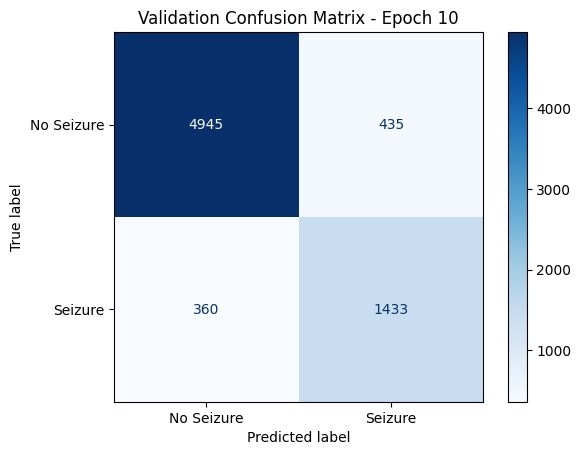


Epoch 11 | Train Loss: 0.4106 | Acc: 0.8710 | F1: 0.7625
           Val Loss: 0.4087 | Acc: 0.8968 | F1: 0.7933

Confusion Matrix (Validation Epoch 11):
[[5013  367]
 [ 373 1420]]
TN: 5013, FP: 367, FN: 373, TP: 1420
              precision    recall  f1-score   support

  No Seizure     0.9307    0.9318    0.9313      5380
     Seizure     0.7946    0.7920    0.7933      1793

    accuracy                         0.8968      7173
   macro avg     0.8627    0.8619    0.8623      7173
weighted avg     0.8967    0.8968    0.8968      7173


Epoch 12 | Train Loss: 0.3971 | Acc: 0.8803 | F1: 0.7784
           Val Loss: 0.4099 | Acc: 0.9052 | F1: 0.8043

Confusion Matrix (Validation Epoch 12):
[[5096  284]
 [ 396 1397]]
TN: 5096, FP: 284, FN: 396, TP: 1397
              precision    recall  f1-score   support

  No Seizure     0.9279    0.9472    0.9375      5380
     Seizure     0.8311    0.7791    0.8043      1793

    accuracy                         0.9052      7173
   macro avg     0.

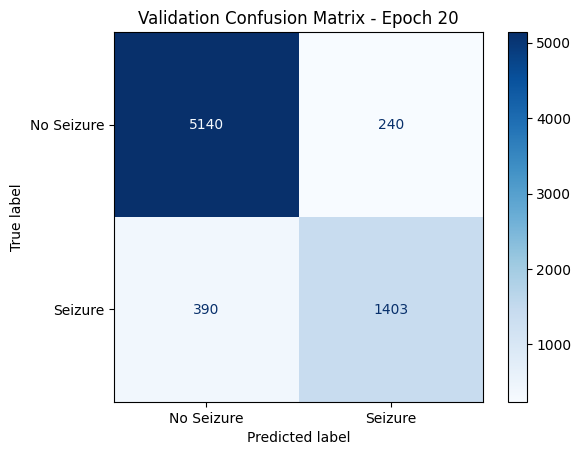


Epoch 21 | Train Loss: 0.3402 | Acc: 0.9087 | F1: 0.8296
           Val Loss: 0.3869 | Acc: 0.9141 | F1: 0.8235

Confusion Matrix (Validation Epoch 21):
[[5120  260]
 [ 356 1437]]
TN: 5120, FP: 260, FN: 356, TP: 1437
              precision    recall  f1-score   support

  No Seizure     0.9350    0.9517    0.9433      5380
     Seizure     0.8468    0.8015    0.8235      1793

    accuracy                         0.9141      7173
   macro avg     0.8909    0.8766    0.8834      7173
weighted avg     0.9129    0.9141    0.9133      7173


Epoch 22 | Train Loss: 0.3337 | Acc: 0.9103 | F1: 0.8321
           Val Loss: 0.3872 | Acc: 0.8705 | F1: 0.7687

Confusion Matrix (Validation Epoch 22):
[[4700  680]
 [ 249 1544]]
TN: 4700, FP: 680, FN: 249, TP: 1544
              precision    recall  f1-score   support

  No Seizure     0.9497    0.8736    0.9101      5380
     Seizure     0.6942    0.8611    0.7687      1793

    accuracy                         0.8705      7173
   macro avg     0.

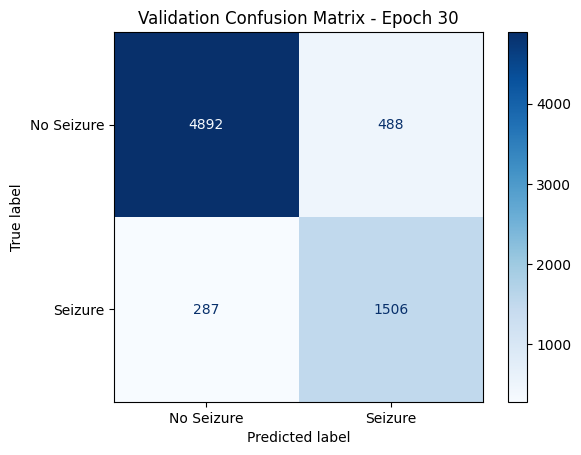


Epoch 31 | Train Loss: 0.2990 | Acc: 0.9253 | F1: 0.8602
           Val Loss: 0.3997 | Acc: 0.8787 | F1: 0.7800

Confusion Matrix (Validation Epoch 31):
[[4761  619]
 [ 251 1542]]
TN: 4761, FP: 619, FN: 251, TP: 1542
              precision    recall  f1-score   support

  No Seizure     0.9499    0.8849    0.9163      5380
     Seizure     0.7136    0.8600    0.7800      1793

    accuracy                         0.8787      7173
   macro avg     0.8317    0.8725    0.8481      7173
weighted avg     0.8908    0.8787    0.8822      7173

No >0.0100% F1 improvement | Count: 1/10

Epoch 32 | Train Loss: 0.2949 | Acc: 0.9255 | F1: 0.8619
           Val Loss: 0.3941 | Acc: 0.8821 | F1: 0.7829

Confusion Matrix (Validation Epoch 32):
[[4802  578]
 [ 268 1525]]
TN: 4802, FP: 578, FN: 268, TP: 1525
              precision    recall  f1-score   support

  No Seizure     0.9471    0.8926    0.9190      5380
     Seizure     0.7252    0.8505    0.7829      1793

    accuracy                    

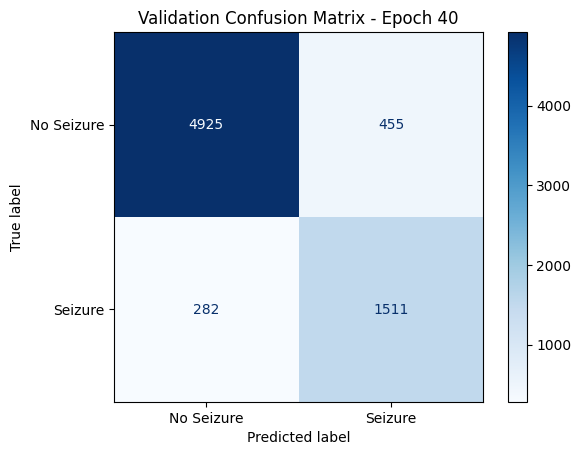

No >0.0100% F1 improvement | Count: 1/10

Epoch 41 | Train Loss: 0.2687 | Acc: 0.9432 | F1: 0.8927
           Val Loss: 0.4200 | Acc: 0.8765 | F1: 0.7761

Confusion Matrix (Validation Epoch 41):
[[4751  629]
 [ 257 1536]]
TN: 4751, FP: 629, FN: 257, TP: 1536
              precision    recall  f1-score   support

  No Seizure     0.9487    0.8831    0.9147      5380
     Seizure     0.7095    0.8567    0.7761      1793

    accuracy                         0.8765      7173
   macro avg     0.8291    0.8699    0.8454      7173
weighted avg     0.8889    0.8765    0.8801      7173

No >0.0100% F1 improvement | Count: 2/10

Epoch 42 | Train Loss: 0.2640 | Acc: 0.9437 | F1: 0.8935
           Val Loss: 0.4317 | Acc: 0.9200 | F1: 0.8290

Confusion Matrix (Validation Epoch 42):
[[5208  172]
 [ 402 1391]]
TN: 5208, FP: 172, FN: 402, TP: 1391
              precision    recall  f1-score   support

  No Seizure     0.9283    0.9680    0.9478      5380
     Seizure     0.8900    0.7758    0.8290   

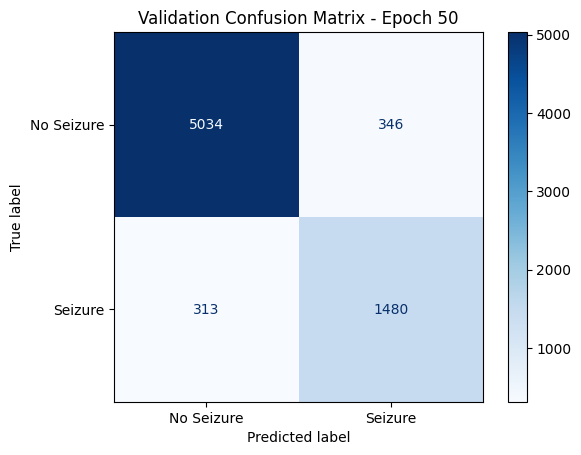

No >0.0100% F1 improvement | Count: 2/10

Epoch 51 | Train Loss: 0.2490 | Acc: 0.9543 | F1: 0.9127
           Val Loss: 0.4326 | Acc: 0.9169 | F1: 0.8278

Confusion Matrix (Validation Epoch 51):
[[5144  236]
 [ 360 1433]]
TN: 5144, FP: 236, FN: 360, TP: 1433
              precision    recall  f1-score   support

  No Seizure     0.9346    0.9561    0.9452      5380
     Seizure     0.8586    0.7992    0.8278      1793

    accuracy                         0.9169      7173
   macro avg     0.8966    0.8777    0.8865      7173
weighted avg     0.9156    0.9169    0.9159      7173


Epoch 52 | Train Loss: 0.2429 | Acc: 0.9574 | F1: 0.9185
           Val Loss: 0.4243 | Acc: 0.8835 | F1: 0.7881

Confusion Matrix (Validation Epoch 52):
[[4782  598]
 [ 238 1555]]
TN: 4782, FP: 598, FN: 238, TP: 1555
              precision    recall  f1-score   support

  No Seizure     0.9526    0.8888    0.9196      5380
     Seizure     0.7222    0.8673    0.7881      1793

    accuracy                    

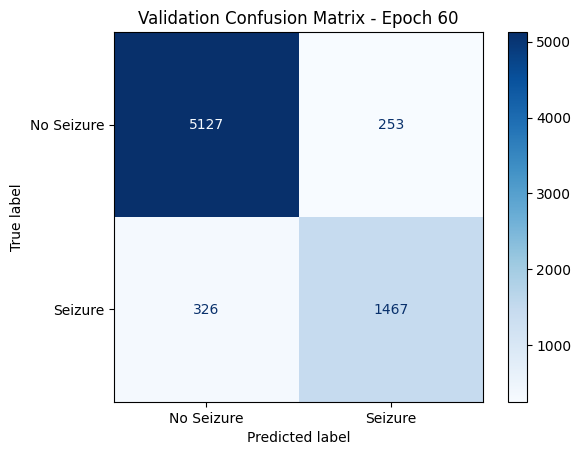


Epoch 61 | Train Loss: 0.2315 | Acc: 0.9626 | F1: 0.9280
           Val Loss: 0.4369 | Acc: 0.9253 | F1: 0.8404

Confusion Matrix (Validation Epoch 61):
[[5226  154]
 [ 382 1411]]
TN: 5226, FP: 154, FN: 382, TP: 1411
              precision    recall  f1-score   support

  No Seizure     0.9319    0.9714    0.9512      5380
     Seizure     0.9016    0.7869    0.8404      1793

    accuracy                         0.9253      7173
   macro avg     0.9167    0.8792    0.8958      7173
weighted avg     0.9243    0.9253    0.9235      7173


Epoch 62 | Train Loss: 0.2352 | Acc: 0.9614 | F1: 0.9255
           Val Loss: 0.4110 | Acc: 0.9123 | F1: 0.8248

Confusion Matrix (Validation Epoch 62):
[[5063  317]
 [ 312 1481]]
TN: 5063, FP: 317, FN: 312, TP: 1481
              precision    recall  f1-score   support

  No Seizure     0.9420    0.9411    0.9415      5380
     Seizure     0.8237    0.8260    0.8248      1793

    accuracy                         0.9123      7173
   macro avg     0.

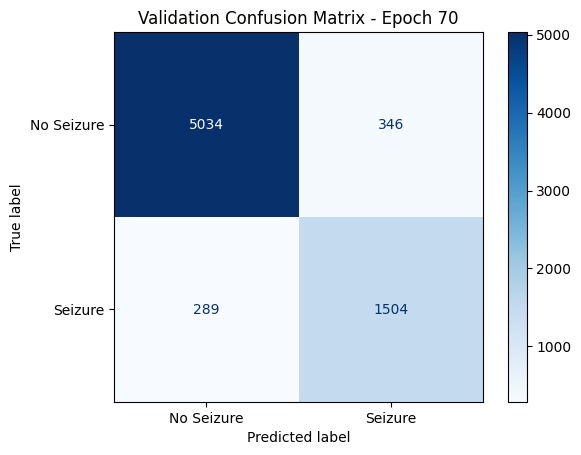

No >0.0100% F1 improvement | Count: 1/10

Epoch 71 | Train Loss: 0.2186 | Acc: 0.9716 | F1: 0.9448
           Val Loss: 0.4185 | Acc: 0.9138 | F1: 0.8281

Confusion Matrix (Validation Epoch 71):
[[5066  314]
 [ 304 1489]]
TN: 5066, FP: 314, FN: 304, TP: 1489
              precision    recall  f1-score   support

  No Seizure     0.9434    0.9416    0.9425      5380
     Seizure     0.8258    0.8305    0.8281      1793

    accuracy                         0.9138      7173
   macro avg     0.8846    0.8860    0.8853      7173
weighted avg     0.9140    0.9138    0.9139      7173


Epoch 72 | Train Loss: 0.2163 | Acc: 0.9733 | F1: 0.9480
           Val Loss: 0.4205 | Acc: 0.9184 | F1: 0.8342

Confusion Matrix (Validation Epoch 72):
[[5116  264]
 [ 321 1472]]
TN: 5116, FP: 264, FN: 321, TP: 1472
              precision    recall  f1-score   support

  No Seizure     0.9410    0.9509    0.9459      5380
     Seizure     0.8479    0.8210    0.8342      1793

    accuracy                    

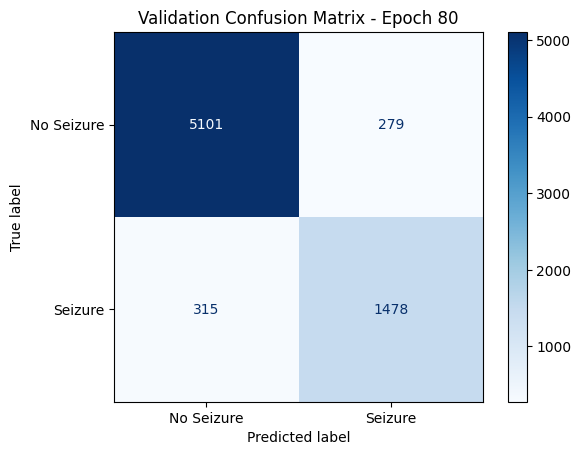

No >0.0100% F1 improvement | Count: 2/10

Epoch 81 | Train Loss: 0.2140 | Acc: 0.9742 | F1: 0.9497
           Val Loss: 0.4173 | Acc: 0.9152 | F1: 0.8305

Confusion Matrix (Validation Epoch 81):
[[5075  305]
 [ 303 1490]]
TN: 5075, FP: 305, FN: 303, TP: 1490
              precision    recall  f1-score   support

  No Seizure     0.9437    0.9433    0.9435      5380
     Seizure     0.8301    0.8310    0.8305      1793

    accuracy                         0.9152      7173
   macro avg     0.8869    0.8872    0.8870      7173
weighted avg     0.9153    0.9152    0.9153      7173

No >0.0100% F1 improvement | Count: 3/10

Epoch 82 | Train Loss: 0.2137 | Acc: 0.9753 | F1: 0.9517
           Val Loss: 0.4182 | Acc: 0.9145 | F1: 0.8301

Confusion Matrix (Validation Epoch 82):
[[5062  318]
 [ 295 1498]]
TN: 5062, FP: 318, FN: 295, TP: 1498
              precision    recall  f1-score   support

  No Seizure     0.9449    0.9409    0.9429      5380
     Seizure     0.8249    0.8355    0.8301   

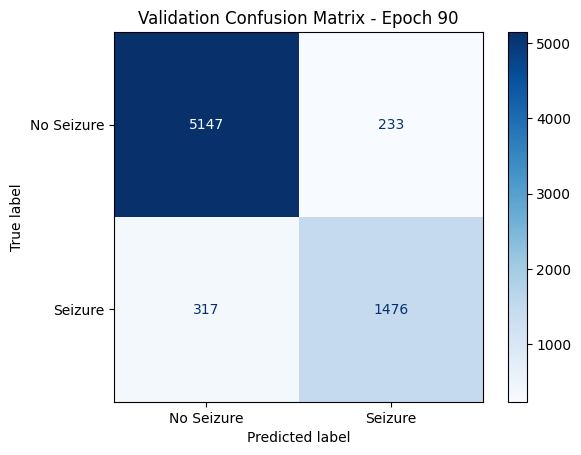


Epoch 91 | Train Loss: 0.2041 | Acc: 0.9782 | F1: 0.9573
           Val Loss: 0.4227 | Acc: 0.9226 | F1: 0.8417

Confusion Matrix (Validation Epoch 91):
[[5143  237]
 [ 318 1475]]
TN: 5143, FP: 237, FN: 318, TP: 1475
              precision    recall  f1-score   support

  No Seizure     0.9418    0.9559    0.9488      5380
     Seizure     0.8616    0.8226    0.8417      1793

    accuracy                         0.9226      7173
   macro avg     0.9017    0.8893    0.8952      7173
weighted avg     0.9217    0.9226    0.9220      7173

No >0.0100% F1 improvement | Count: 1/10

Epoch 92 | Train Loss: 0.2089 | Acc: 0.9775 | F1: 0.9560
           Val Loss: 0.4195 | Acc: 0.9229 | F1: 0.8419

Confusion Matrix (Validation Epoch 92):
[[5148  232]
 [ 321 1472]]
TN: 5148, FP: 232, FN: 321, TP: 1472
              precision    recall  f1-score   support

  No Seizure     0.9413    0.9569    0.9490      5380
     Seizure     0.8638    0.8210    0.8419      1793

    accuracy                    

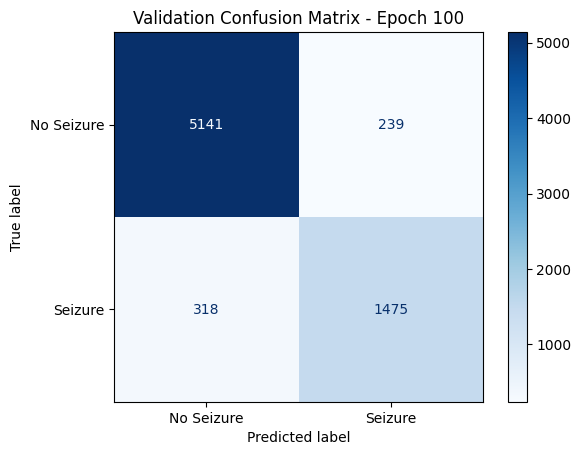


Best Validation (argmax): Epoch 88 | Acc: 0.9246 | F1: 0.8447
Calibrated temperature T = 0.990

Post-hoc threshold sweep (calibrated VAL):
Chosen τ = 0.76 | Val F1=0.847 | Val Acc=0.928


In [81]:
# ===========================================
# EEG Seizure ConvSNN: Smoothing + Calibration + Confusion Matrix + Threshold Sweep
# ===========================================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import surrogate

# ----------------------------
# Config
# ----------------------------
BATCH_SIZE   = 64
EPOCHS       = 100
MAX_LR       = 8e-4
WEIGHT_DECAY = 2e-4
CLIP_NORM    = 1.0

TIME_POOL    = 2               # keep more temporal detail
CH_DROP_P    = 0.15            # channel dropout (train)
TIME_MASK_P  = 0.15            # simple time masking (train)
TIME_MASK_LEN= 4

USE_LATENCY_ENCODING = True    # stack latency-coded spikes
LATENCY_THR  = 1.0             # threshold for latency encoding

VAL_THRESH_SWEEP = (0.2, 0.8, 0.01)  # min, max, step
PLOT_CM_EVERY    = 10                # plot confusion matrix every N epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Expect X_balanced (N,C,T), y_balanced (N,)
# ----------------------------
try:
    X_balanced, y_balanced
except NameError:
    raise RuntimeError("Please define X_balanced (N,C,T) and y_balanced (N,) before running.")

# ----------------------------
# Optional: add a latency-coded spike stream and stack with current spikes
# ----------------------------
def latency_encode_window(chx: np.ndarray, thr: float=1.0) -> np.ndarray:
    idx = np.argmax(chx > thr)
    out = np.zeros_like(chx, dtype=np.float32)
    if chx[idx] > thr:
        out[idx] = 1.0
    return out

def latency_encode_batch(X_ncT: np.ndarray, thr: float=1.0) -> np.ndarray:
    N, C, T = X_ncT.shape
    out = np.zeros_like(X_ncT, dtype=np.float32)
    for n in range(N):
        for c in range(C):
            out[n, c] = latency_encode_window(X_ncT[n, c], thr)
    return out

if USE_LATENCY_ENCODING:
    print("Building latency-coded spikes...")
    X_lat = latency_encode_batch(X_balanced, thr=LATENCY_THR)   # (N,C,T)
    X_input = np.concatenate([X_balanced, X_lat], axis=1)       # (N,2C,T)
else:
    X_input = X_balanced

N, C_in_total, T_len = X_input.shape
print(f"Input shape: {X_input.shape} (N,C,T)")

# ----------------------------
# Dataset with time pooling & light augmentation
# ----------------------------
class SpikeDataset(Dataset):
    def __init__(self, X, y, time_pool=2, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4, train=True):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.time_pool = time_pool
        self.channel_dropout_p = channel_dropout_p if train else 0.0
        self.time_mask_prob = time_mask_prob if train else 0.0
        self.time_mask_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (C, T)
        y = self.y[idx]
        C, T = x.shape

        # Channel dropout
        if self.channel_dropout_p > 0:
            mask = (torch.rand(C) > self.channel_dropout_p).float()
            x = x * mask.view(C, 1)

        # Time mask
        if self.time_mask_prob > 0 and torch.rand(1).item() < self.time_mask_prob and T > self.time_mask_len:
            t0 = torch.randint(0, T - self.time_mask_len + 1, (1,)).item()
            x[:, t0:t0+self.time_mask_len] = 0.0

        # Max-pool over time
        if self.time_pool > 1:
            Ttrim = (T // self.time_pool) * self.time_pool
            x = x[:, :Ttrim]
            x = x.view(C, -1, self.time_pool).amax(dim=2)  # (C, T/time_pool)

        # to (T, C) for SNN
        x = x.permute(1, 0).contiguous()  # (T, C)
        return x, y

# ----------------------------
# Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_input, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Train seizure ratio:", float(np.mean(y_train)), "Val seizure ratio:", float(np.mean(y_val)))

train_loader = DataLoader(SpikeDataset(X_train, y_train, time_pool=TIME_POOL, channel_dropout_p=CH_DROP_P, time_mask_prob=TIME_MASK_P, time_mask_len=TIME_MASK_LEN, train=True),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(SpikeDataset(X_val,   y_val,   time_pool=TIME_POOL, channel_dropout_p=0.0,       time_mask_prob=0.0,      time_mask_len=0,             train=False),
                          batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ----------------------------
# ConvSNN (Residual + Temporal Attention) with LN in SNN head
# ----------------------------
def beta_from_tau(dt_ms: float, tau_ms: float) -> float:
    dt = max(1e-6, float(dt_ms))
    tau = max(1e-6, float(tau_ms))
    return float(np.exp(-dt / tau))

class ResDSConv1D(nn.Module):
    def __init__(self, c_in, c_out, ksize=9, stride=1, drop=0.1):
        super().__init__()
        pad = ksize // 2
        self.dw = nn.Conv1d(c_in, c_in, ksize, stride=stride, padding=pad, groups=c_in, bias=False)
        self.bn1 = nn.BatchNorm1d(c_in, eps=1e-4, momentum=0.1)
        self.pw = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
        self.drop = nn.Dropout(drop)
        self.act  = nn.GELU()
        self.down = None
        if stride != 1 or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv1d(c_in, c_out, 1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out, eps=1e-4, momentum=0.1)
            )
    def forward(self, x):  # (B,C_in,T)
        y = self.dw(x); y = self.bn1(y); y = self.act(y)
        y = self.pw(y); y = self.bn2(y); y = self.drop(y)
        s = x if self.down is None else self.down(x)
        return self.act(y + s)  # (B,C_out,T')

class TemporalMHSA(nn.Module):
    def __init__(self, channels, num_heads=4, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=attn_drop, batch_first=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.norm = nn.LayerNorm(channels)
    def forward(self, x_bct):  # (B,C,T)
        B, C, T = x_bct.shape
        x_btc = x_bct.transpose(1, 2).contiguous()  # (B,T,C)
        x_norm = self.norm(x_btc)
        out, _ = self.mha(x_norm, x_norm, x_norm, need_weights=False)
        out = self.proj_drop(out)
        out = out + x_btc
        return out.transpose(1, 2).contiguous()     # (B,C,T)

class ConvSNN_ResAttn(nn.Module):
    def __init__(self, n_inputs, n_outputs, *,
                 stem_width=96, blocks=2, ksize=9, strides=(1,1),
                 attn_heads=4, attn_drop=0.0, proj_drop=0.0,
                 snn_hidden=192, dt_ms=4.0, tau_ms=20.0, dropout=0.20,
                 slope=12.0, learn_beta=True):
        super().__init__()
        beta = beta_from_tau(dt_ms, tau_ms)
        # stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_inputs, stem_width, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_width, eps=1e-4, momentum=0.1),
            nn.GELU()
        )
        # residual temporal blocks
        _strides = list(strides) + [1] * max(0, blocks - len(strides))
        feats, c_in = [], stem_width
        for b in range(blocks):
            feats.append(ResDSConv1D(c_in, stem_width, ksize=ksize, stride=_strides[b], drop=0.1))
            c_in = stem_width
        self.feats = nn.Sequential(*feats)
        # attention
        self.attn = TemporalMHSA(stem_width, num_heads=attn_heads, attn_drop=attn_drop, proj_drop=proj_drop)
        # spiking head (LayerNorm for small-batch stability)
        self.fc1  = nn.Linear(stem_width, snn_hidden)
        self.ln1  = nn.LayerNorm(snn_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)
        self.fc_out  = nn.Linear(snn_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):     # (T,B,C)
        x_bct = x_tm.permute(1, 2, 0).contiguous()  # (B,C,T)
        feat = self.stem(x_bct)
        feat = self.feats(feat)
        feat = self.attn(feat)
        B, W, Tprime = feat.shape
        dev = x_tm.device
        feat_tbc = feat.permute(2, 0, 1).contiguous()  # (T',B,W)

        mem1 = torch.zeros(B, self.fc1.out_features, device=dev)
        memo = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(Tprime):
            ft = feat_tbc[t]
            h1 = self.fc1(ft)
            h1 = self.ln1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)

            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / Tprime  # logits (B, n_outputs)

# ----------------------------
# Instantiate model
# ----------------------------
C_in = X_train.shape[1]  # channels (after stack if enabled)
model = ConvSNN_ResAttn(
    n_inputs=C_in, n_outputs=2,
    stem_width=96, blocks=2, ksize=9, strides=(1,1),
    attn_heads=4, attn_drop=0.0, proj_drop=0.0,
    snn_hidden=256, dt_ms=4.0, tau_ms=20.0, dropout=0.20, slope=12.0, learn_beta=True
).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ----------------------------
# Loss: weighted CE + label smoothing (stable)
# ----------------------------
unique, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = max(counts) if len(counts) else 1
num_classes = int(max(unique)) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
if num_classes >= 2:
    weights[1] *= 1.2   # gently emphasize seizure class
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

# ----------------------------
# Optim / Scheduler
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.3
)

# ----------------------------
# Train with early stop on F1 + Confusion Matrix
# ----------------------------
best_val_acc = 0.0
best_val_f1  = 0.0
best_epoch   = 0
last_val_f1  = 0.0
epochs_no_improve = 0
patience = 10
min_improvement = 1e-4

for epoch in range(EPOCHS):
    # -------- TRAIN --------
    model.train()
    total_loss, all_preds, all_targets = 0.0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)       # xb: (B,T,C)
        xb = xb.permute(1, 0, 2).contiguous()       # -> (T,B,C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                          # (B,2)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * yb.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().numpy())
        all_targets.extend(yb.detach().cpu().numpy())

    train_acc = accuracy_score(all_targets, all_preds)
    train_f1  = f1_score(all_targets, all_preds)
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"\nEpoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * yb.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_f1  = f1_score(val_targets, val_preds)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"           Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # -------- CONFUSION MATRIX (VAL) --------
    cm = confusion_matrix(val_targets, val_preds, labels=[0,1])
    print(f"\nConfusion Matrix (Validation Epoch {epoch+1}):\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    report = classification_report(val_targets, val_preds, target_names=["No Seizure", "Seizure"], digits=4)
    print(report)
    if (epoch + 1) % PLOT_CM_EVERY == 0:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Seizure", "Seizure"])
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Validation Confusion Matrix - Epoch {epoch+1}")
        plt.show()

    # -------- TRACK BEST --------
    improved = False
    if (val_f1 - best_val_f1) > min_improvement or (abs(val_f1 - best_val_f1) <= min_improvement and val_acc > best_val_acc):
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        improved = True

    if (val_f1 - last_val_f1) <= min_improvement and not improved:
        epochs_no_improve += 1
        print(f"No >{min_improvement*100:.4f}% F1 improvement | Count: {epochs_no_improve}/{patience}")
    else:
        epochs_no_improve = 0

    last_val_f1 = val_f1
    if epochs_no_improve >= patience:
        print(f"Early stopping: No >{min_improvement*100:.4f}% F1 improvement for {patience} epochs.")
        break

print(f"\nBest Validation (argmax): Epoch {best_epoch:02d} | Acc: {best_val_acc:.4f} | F1: {best_val_f1:.4f}")

# ----------------------------
# Temperature scaling (calibration) on validation logits
# ----------------------------
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_temp = nn.Parameter(torch.zeros(1))  # T=1 init
    def forward(self, logits):
        T = self.log_temp.exp()
        return logits / T

def fit_temperature(model, val_loader, device):
    model.eval()
    scaler = TemperatureScaler().to(device)
    opt = torch.optim.LBFGS(scaler.parameters(), lr=0.1, max_iter=50)

    # collect val logits/targets
    all_logits, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).permute(1,0,2).contiguous()
            logits = model(xb)
            all_logits.append(logits.detach())
            all_tgts.append(yb.to(device))
    all_logits = torch.cat(all_logits, 0)
    all_tgts   = torch.cat(all_tgts,   0)

    nll = nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad()
        loss = nll(scaler(all_logits), all_tgts)
        loss.backward()
        return loss

    opt.step(closure)
    with torch.no_grad():
        T = scaler.log_temp.exp().item()
    print(f"Calibrated temperature T = {T:.3f}")
    return scaler

scaler = fit_temperature(model, val_loader, device)

# ----------------------------
# Post-hoc threshold sweep (on CALIBRATED probabilities)
# ----------------------------
model.eval()
val_logits_all, val_y_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).permute(1,0,2).contiguous()
        logits = model(xb)
        logits = scaler(logits)  # calibrated logits
        val_logits_all.append(logits.cpu())
        val_y_all.append(yb)

val_logits_all = torch.cat(val_logits_all, 0).numpy()
val_y_all = torch.cat(val_y_all, 0).numpy()

probs = torch.softmax(torch.tensor(val_logits_all), dim=1).numpy()[:,1]  # P(seizure)
t_min, t_max, t_step = VAL_THRESH_SWEEP
taus = np.arange(t_min, t_max + 1e-9, t_step)

best_tau, best_f1, best_acc = 0.5, 0.0, 0.0
for t in taus:
    pred = (probs >= t).astype(int)
    f1  = f1_score(val_y_all, pred)
    acc = accuracy_score(val_y_all, pred)
    if f1 > best_f1 or (abs(f1 - best_f1) <= 1e-8 and acc > best_acc):
        best_tau, best_f1, best_acc = float(t), float(f1), float(acc)

print(f"\nPost-hoc threshold sweep (calibrated VAL):")
print(f"Chosen τ = {best_tau:.2f} | Val F1={best_f1:.3f} | Val Acc={best_acc:.3f}")
# Example inference rule:
# y_pred = (softmax(scaler(model(xb)))[:,1] >= best_tau).int()
